# 0. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. 데이터 전처리

##### 사용할 함수정의

In [2]:
# 결측값을 높은 빈도 값으로 채우는 함수
def frequency_apply(df, criteria_col, target_col, n=0):
    if df[criteria_col].isnull().sum() > 0:
        print("Impossible if there are None : ",criteria_col)
        return
    
    if df[target_col].isnull().sum() > 0:
        print("Impossible if there are None : ",target_col)
        return
    
    target_index = df.loc[df[target_col] == 0][target_col].groupby(df[criteria_col]).count().index
    
    for i in range(0,len(target_index)):
        arr_value = df.loc[df[criteria_col] == target_index[i]][criteria_col].groupby(df[target_col]).count()
        max_value = df.loc[df[criteria_col] == target_index[i]][criteria_col].groupby(df[target_col]).count().max()
        
        for j in range(0,len(arr_value)):
            if max_value == arr_value.values[j]:
                k = j
                break
                
        change = df.loc[df[criteria_col] == target_index[i]][criteria_col].groupby(df[target_col]).count().index[k]        
        df.loc[(df[target_col] == n) & (df[criteria_col] == target_index[i]),target_col] = change
        
# 특정 컬럼의 널값 퍼센테이지를 확인하는 함수        
def None_percentage(df, col):
    per = df[col].isnull().sum() / df.shape[0]
    return print(col,"의 None값 ",round(per,4) * 100,"%")        

def col_diff(df1, df2):
    col = []
    for i in range(0,len(df1.columns)):
        for j in range(0,len(df2.columns)):
            if df1.columns[i] == df2.columns[j]:
                col.append(df1.columns[i])
    print("join columns : ",col)            
    return col


def str_col(df):
    col = []
    for i in range(0,len(df.dtypes)):
        if str(df.dtypes[i]) == 'object':
            col.append(df.dtypes.index[i])
    print(col)        
    return col


def int_col(df):
    col = []
    for i in range(0,len(df.dtypes)):
        if str(df.dtypes[i]) != 'object':
            col.append(df.dtypes.index[i])
    print(col)        
    return col 

def unique_check(df):
    
    for i in range(0,len(df.columns)):
        if df[df.columns[i]].isnull().sum() > 0:
            print("Impossible if there are None : ",df.columns[i])
        
    col_1 = []
    col_2 = []
    for i in range(0,len(df.columns)):
        if type(df[df.columns[i]][0]) == str:
            col_1.append(df.columns[i])
            
            if df[df.columns[i]].nunique() > 5:
                col_2.append(df.columns[i])
                print(df.columns[i],"컬럼의 unique 개수는 ",df[df.columns[i]].nunique(),"개")
                
    return col_1, col_2    

def p_100(a, b):
    print( round( (a/(a+b))*100,2), "%" )

# 1 - 1  고객 특성 데이터 전처리 

In [3]:
CUST = pd.read_csv('./dataset/real_insurance_data/BGCON_CUST_DATA_2.csv',delimiter = None,encoding='utf-8')
print(CUST.shape)
print(CUST.dtypes)
print(CUST.isnull().sum())
CUST.tail(5)

(22400, 25)
CUST_ID               int64
DIVIDED_SET           int64
SIU_CUST_YN          object
SEX                   int64
AGE                   int64
RESI_COST             int64
RESI_TYPE_CODE      float64
FP_CAREER            object
CUST_RGST           float64
CTPR                 object
OCCP_GRP_1           object
OCCP_GRP_2           object
TOTALPREM           float64
MINCRDT             float64
MAXCRDT             float64
WEDD_YN              object
MATE_OCCP_GRP_1      object
MATE_OCCP_GRP_2      object
CHLD_CNT            float64
LTBN_CHLD_AGE       float64
MAX_PAYM_YM         float64
MAX_PRM             float64
CUST_INCM           float64
RCBASE_HSHD_INCM      int64
JPBASE_HSHD_INCM    float64
dtype: object
CUST_ID                 0
DIVIDED_SET             0
SIU_CUST_YN          1793
SEX                     0
AGE                     0
RESI_COST               0
RESI_TYPE_CODE       1254
FP_CAREER               0
CUST_RGST             456
CTPR                  621
OCCP_GRP_1    

,CUST_ID,DIVIDED_SET,SIU_CUST_YN,SEX,AGE,RESI_COST,RESI_TYPE_CODE,FP_CAREER,CUST_RGST,CTPR,...,WEDD_YN,MATE_OCCP_GRP_1,MATE_OCCP_GRP_2,CHLD_CNT,LTBN_CHLD_AGE,MAX_PAYM_YM,MAX_PRM,CUST_INCM,RCBASE_HSHD_INCM,JPBASE_HSHD_INCM
22395,20048,2,NaN,1,34,5652,11.0,N,201103.0,경북,...,N,NaN,NaN,0.0,0.0,NaN,NaN,3331.0,3622,3331.0
22396,21483,1,N,2,30,31944,20.0,N,200306.0,경기,...,N,NaN,NaN,0.0,0.0,NaN,NaN,0.0,9361,8947.0
22397,21940,1,N,2,23,45972,20.0,N,200501.0,경기,...,N,NaN,NaN,0.0,0.0,NaN,NaN,0.0,11522,11484.0
22398,20356,1,N,1,15,27777,20.0,N,200306.0,경기,...,N,NaN,NaN,0.0,0.0,NaN,NaN,NaN,7960,7614.0
22399,17118,1,N,2,18,21527,20.0,N,200306.0,경기,...,N,NaN,NaN,0.0,0.0,NaN,NaN,NaN,7746,7746.0


##### DIVIDED_SET컬럼의 2번 데이터는 경진대회 문제지 (제외) : SIU_CUST_YN(정답지)컬럼의 null값도 사라짐

In [4]:
None_percentage(CUST, 'SIU_CUST_YN')
CUST_NY = CUST.loc[CUST['DIVIDED_SET'] == 1]

SIU_CUST_YN 의 None값  8.0 %


##### CTPR(시도구분)컬럼의 null값은 가장 많은 지역인 경기도로 변경

In [5]:
None_percentage(CUST_NY, 'CTPR')
CUST_NY.loc[CUST_NY['CTPR'].isnull(),'CTPR'] = '경기'

CTPR 의 None값  2.79 %


##### RESI_TYPE_CODE(거주TYPE)컬럼의 null값은 시도구분 컬럼 기준으로 많은 type의 건물로 맵핑

In [6]:
None_percentage(CUST_NY, 'RESI_TYPE_CODE')

CUST_NY['RESI_TYPE_CODE'] = CUST_NY['RESI_TYPE_CODE'].fillna(0, axis=0)

frequency_apply(CUST_NY, 'CTPR', 'RESI_TYPE_CODE')

CUST_NY = CUST_NY.astype({'RESI_TYPE_CODE': str})

RESI_TYPE_CODE 의 None값  5.56 %


##### RESI_COST(주택가격)컬럼의 null값은 거주TYPE기준으로 groupby진행해서 평균값으로 변경
##### 거주TYPE이 '숙박업소의 객실 또는 판자집'으로 되어있는 경우 0원으로 변경

In [7]:
print(CUST_NY['RESI_COST'].describe())

None_percentage(CUST_NY, 'RESI_COST')

CTPR_index = CUST_NY['CUST_ID'].groupby(CUST_NY['CTPR']).count().index

# RESI_COST컬럼의 결측값을 채워줌
for i in range(0,len(CTPR_index)):
    list_1 = CUST_NY.loc[(CUST_NY['CTPR'] == CTPR_index[i]) & (CUST_NY['RESI_COST']!=0)]['RESI_COST'].groupby(CUST_NY['RESI_TYPE_CODE']).median()
    
    for j in range(0,len(list_1)):
        # CUST_NY.loc[(CUST_NY['CTPR'] == CTPR_index[i]) & (CUST_NY['RESI_COST'] == 0),'RESI_COST'] = list_1.index[np.argmax(list_1)]
        if len(CUST_NY.loc[(CUST_NY['CTPR'] == CTPR_index[i]) & (CUST_NY['RESI_COST']==0) & (CUST_NY['RESI_TYPE_CODE'] == list_1.index[j])]) > 0:
            CUST_NY.loc[(CUST_NY['CTPR'] == CTPR_index[i]) & (CUST_NY['RESI_COST']==0) & (CUST_NY['RESI_TYPE_CODE'] == list_1.index[j]),'RESI_COST'] = list_1.values[j]    

count     20607.000000
mean      15944.537293
std       14897.582633
min           0.000000
25%        6748.000000
50%       12222.000000
75%       21111.000000
max      249503.000000
Name: RESI_COST, dtype: float64
RESI_COST 의 None값  0.0 %


##### CUST_RGST(고객등록년월)컬럼은 2016년 8월을 기준으로 얼마나 가입했는지 나타내도록 변경함. null값은 평균 가입일수로 변경

In [8]:
print(CUST_NY['CUST_RGST'].describe())

None_percentage(CUST_NY, 'CUST_RGST')

CUST_NY.loc[CUST_NY['CUST_RGST'].notnull()]['CUST_ID'].groupby(CUST_NY['CUST_RGST']).count().index > 99999

CUST_NY.loc[CUST_NY['CUST_RGST']==101,'CUST_RGST'] = 0
CUST_NY['CUST_RGST'] = CUST_NY['CUST_RGST'].fillna(0,axis=0)

CUST_NY = CUST_NY.astype({'CUST_RGST': int})

CUST_NY = CUST_NY.astype({'CUST_RGST': str})

CUST_NY


CUST_NY.loc[CUST_NY['CUST_RGST'] != '0','CUST_RGST'] = (dt.datetime(2016, 8, 1) - pd.to_datetime(CUST_NY.loc[CUST_NY['CUST_RGST'] != '0']['CUST_RGST'],format='%Y%m')).dt.days

sum_value = 0
temp = len(CUST_NY.loc[CUST_NY['CUST_RGST'] != '0']['CUST_ID'].groupby(CUST_NY['CUST_RGST']).count().index)

for i in range(0,temp):
    sum_value = sum_value + CUST_NY.loc[CUST_NY['CUST_RGST'] != '0']['CUST_ID'].groupby(CUST_NY['CUST_RGST']).count().index[i]
mean_value = sum_value / temp  

CUST_NY.loc[CUST_NY['CUST_RGST'] == '0','CUST_RGST'] = int(mean_value)
CUST_NY = CUST_NY.astype({'CUST_RGST':float})

count     20188.000000
mean     198907.676392
std       17088.418731
min         101.000000
25%      200306.000000
50%      200306.000000
75%      200401.000000
max      201602.000000
Name: CUST_RGST, dtype: float64
CUST_RGST 의 None값  2.03 %


##### OCCP_GRP_1(직업분류코드1)과 OCCP_GRP_2(직업분류코드2)컬럼의 null값은 groupby를 통해 빈도수가 많은 직업분류로 맵핑

In [9]:
None_percentage(CUST_NY, 'OCCP_GRP_1')
None_percentage(CUST_NY, 'OCCP_GRP_2')

num = np.argmax(CUST_NY.loc[CUST_NY['OCCP_GRP_1'].notnull()]['CUST_ID'].groupby(CUST_NY['OCCP_GRP_1']).count())
target = CUST_NY.loc[CUST_NY['OCCP_GRP_1'].notnull()]['CUST_ID'].groupby(CUST_NY['OCCP_GRP_1']).count().index[num]
CUST_NY.loc[CUST_NY['OCCP_GRP_1'].isnull(),'OCCP_GRP_1'] = target

num = np.argmax(CUST_NY.loc[(CUST_NY['OCCP_GRP_2'].notnull()) & (CUST_NY['OCCP_GRP_1'] == target)]['CUST_ID'].groupby(CUST_NY['OCCP_GRP_2']).count())
target = CUST_NY.loc[(CUST_NY['OCCP_GRP_2'].notnull()) & (CUST_NY['OCCP_GRP_1'] == target)]['CUST_ID'].groupby(CUST_NY['OCCP_GRP_2']).count().index[num]
CUST_NY.loc[CUST_NY['OCCP_GRP_2'].isnull(),'OCCP_GRP_2'] = target

OCCP_GRP_1 의 None값  2.65 %
OCCP_GRP_2 의 None값  2.65 %


##### TOTALPREM(납입총보험료)컬럼의 null값은 groupby를 통해 직업군별 중앙값으로 적용

In [10]:
print(CUST_NY['TOTALPREM'].describe())

None_percentage(CUST_NY, 'TOTALPREM')
arr_1 = CUST_NY.loc[CUST_NY['TOTALPREM'].notnull()]['TOTALPREM'].groupby(CUST_NY['OCCP_GRP_1']).median().index
arr_2 = CUST_NY.loc[CUST_NY['TOTALPREM'].notnull()]['TOTALPREM'].groupby(CUST_NY['OCCP_GRP_1']).median().values

for i in range(0,len(arr_1)):
    CUST_NY.loc[(CUST_NY['TOTALPREM'].isnull()) & (CUST_NY['OCCP_GRP_1'] == arr_1[i]), 'TOTALPREM'] = arr_2[i]

count    1.528600e+04
mean     3.010216e+07
std      4.945351e+07
min      5.000000e+02
25%      6.681712e+06
50%      1.618889e+07
75%      3.479242e+07
max      1.840052e+09
Name: TOTALPREM, dtype: float64
TOTALPREM 의 None값  25.82 %


##### WEDD_YN(결혼여부)컬럼의 null값은 N으로 변경

In [11]:
None_percentage(CUST_NY, 'WEDD_YN')
CUST_NY.loc[CUST_NY['WEDD_YN'].isnull(),'WEDD_YN'] = 'N'

WEDD_YN 의 None값  2.11 %


##### MATE_OCCP_GRP_1(배우자직업그룹코드1)과 MATE_OCCP_GRP_2(배우자직업그룹코드2)는 null값의 비중이 크고 null값에 대한 별도의 기준이 없으므로 삭제

In [12]:
None_percentage(CUST_NY, 'MATE_OCCP_GRP_1')
None_percentage(CUST_NY, 'MATE_OCCP_GRP_2')
CUST_NY.drop(['MATE_OCCP_GRP_1','MATE_OCCP_GRP_2'], axis=1, inplace=True)

MATE_OCCP_GRP_1 의 None값  52.82 %
MATE_OCCP_GRP_2 의 None값  52.82 %


##### CHLD_CNT(자녀수)와 LTBN_CHLD_AGE(막내자녀연령)의 null값은 WEDD_YN(결혼여부)컬럼 null값과 행이 동일하므로 모두 0으로 맵핑

In [13]:
None_percentage(CUST_NY, 'CHLD_CNT')
None_percentage(CUST_NY, 'LTBN_CHLD_AGE')

CUST_NY.loc[CUST_NY['CHLD_CNT'].isnull(),'CHLD_CNT'] = 0
CUST_NY.loc[CUST_NY['LTBN_CHLD_AGE'].isnull(),'LTBN_CHLD_AGE'] = 0

CHLD_CNT 의 None값  2.11 %
LTBN_CHLD_AGE 의 None값  2.11 %


##### CUST_INCM(고객추정소득)컬럼의 null값의 각 직업군의 대분류와 소분류를 합친 기준으로 중앙값으로 대체

In [14]:
None_percentage(CUST_NY, 'CUST_INCM')

kinds = CUST_NY.loc[CUST_NY['CUST_INCM'].notnull()].groupby(['OCCP_GRP_1','OCCP_GRP_2'])['CUST_INCM'].median().index
df_target = CUST_NY.loc[CUST_NY['CUST_INCM'].isnull()]
len_1 = len(df_target.index)
len_2 = len(kinds)

for i in range(0,len_1):
    for j in range(0,len_2):
        if df_target['OCCP_GRP_1'].values[i] == kinds[j][0]:
            for k in range(0,len(kinds[j])):
                if df_target['OCCP_GRP_2'].values[i] == kinds[j][k]:
                    discovery = CUST_NY.loc[ (CUST_NY['CUST_INCM'].notnull()) & (CUST_NY['OCCP_GRP_1'] == kinds[j][0])\
                                            & (CUST_NY['OCCP_GRP_2'] == kinds[j][k])]['CUST_INCM'].median()
                    
                    CUST_NY.loc[ (CUST_NY['CUST_INCM'].isnull()) & (CUST_NY['OCCP_GRP_1'] == kinds[j][0])\
                                            & (CUST_NY['OCCP_GRP_2'] == kinds[j][k]),'CUST_INCM'] = discovery 

CUST_INCM 의 None값  23.400000000000002 %


In [15]:
CUST_NY = CUST_NY.loc[CUST_NY['CUST_INCM'].notnull()]                    

##### MAX_PAYM_YM(최대보험료연월), MAX_PRM(최대보험료)컬럼들은 중요해 보이지만 null값의 비중이 크고 null값에 대한 별도의 기준이 없으므로 삭제

In [16]:
None_percentage(CUST_NY, 'MAX_PAYM_YM')
None_percentage(CUST_NY, 'MAX_PRM')

CUST_NY.drop(['MAX_PAYM_YM','MAX_PRM'], axis=1, inplace=True)

MAX_PAYM_YM 의 None값  28.95 %
MAX_PRM 의 None값  28.95 %


##### MAXCRDT(최고신용등급)과 MINCRDT(최저신용등급)컬럼의 null값은 6등급으로 맵핑

In [17]:
None_percentage(CUST_NY, 'MINCRDT')
None_percentage(CUST_NY, 'MAXCRDT')
CUST_NY.loc[CUST_NY['MINCRDT'].isnull(),'MINCRDT'] = 6.0
CUST_NY.loc[CUST_NY['MAXCRDT'].isnull(),'MAXCRDT'] = 6.0

CUST_NY.loc[CUST_NY['MINCRDT'] < 1,'MINCRDT'] = 1
CUST_NY.loc[CUST_NY['MAXCRDT'] < 1,'MAXCRDT'] = 1

CUST_NY.loc[CUST_NY['MINCRDT'] > 10,'MINCRDT'] = 6
CUST_NY.loc[CUST_NY['MAXCRDT'] > 10,'MAXCRDT'] = 6

MINCRDT 의 None값  42.54 %
MAXCRDT 의 None값  42.54 %


##### JPBASE_HSHD_INCM(추정가구소득2)컬럼의 null값은 직업분류컬럼을 groupby해서 평균소득으로 변경함

In [18]:
print(CUST_NY['JPBASE_HSHD_INCM'].describe())

None_percentage(CUST_NY, 'JPBASE_HSHD_INCM')

arr_1 = CUST_NY.loc[CUST_NY['JPBASE_HSHD_INCM'].notnull()]['JPBASE_HSHD_INCM'].groupby(CUST_NY['OCCP_GRP_1']).median().index
arr_2 = CUST_NY.loc[CUST_NY['JPBASE_HSHD_INCM'].notnull()]['JPBASE_HSHD_INCM'].groupby(CUST_NY['OCCP_GRP_1']).median().values

for i in range(0,len(arr_1)):
    CUST_NY.loc[(CUST_NY['JPBASE_HSHD_INCM'].isnull()) & (CUST_NY['OCCP_GRP_1'] == arr_1[i]), 'JPBASE_HSHD_INCM'] = arr_2[i]

count    19990.000000
mean      5204.012856
std       2716.401113
min          0.000000
25%       3558.000000
50%       4686.500000
75%       6848.500000
max      25872.000000
Name: JPBASE_HSHD_INCM, dtype: float64
JPBASE_HSHD_INCM 의 None값  2.9899999999999998 %


##### null값 확인

In [19]:
CUST_NY.isnull().sum()

CUST_ID             0
DIVIDED_SET         0
SIU_CUST_YN         0
SEX                 0
AGE                 0
RESI_COST           0
RESI_TYPE_CODE      0
FP_CAREER           0
CUST_RGST           0
CTPR                0
OCCP_GRP_1          0
OCCP_GRP_2          0
TOTALPREM           0
MINCRDT             0
MAXCRDT             0
WEDD_YN             0
CHLD_CNT            0
LTBN_CHLD_AGE       0
CUST_INCM           0
RCBASE_HSHD_INCM    0
JPBASE_HSHD_INCM    0
dtype: int64

In [20]:
CUST_NY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20606 entries, 0 to 22399
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUST_ID           20606 non-null  int64  
 1   DIVIDED_SET       20606 non-null  int64  
 2   SIU_CUST_YN       20606 non-null  object 
 3   SEX               20606 non-null  int64  
 4   AGE               20606 non-null  int64  
 5   RESI_COST         20606 non-null  float64
 6   RESI_TYPE_CODE    20606 non-null  object 
 7   FP_CAREER         20606 non-null  object 
 8   CUST_RGST         20606 non-null  float64
 9   CTPR              20606 non-null  object 
 10  OCCP_GRP_1        20606 non-null  object 
 11  OCCP_GRP_2        20606 non-null  object 
 12  TOTALPREM         20606 non-null  float64
 13  MINCRDT           20606 non-null  float64
 14  MAXCRDT           20606 non-null  float64
 15  WEDD_YN           20606 non-null  object 
 16  CHLD_CNT          20606 non-null  float6

##### 범주형 데이터인데 숫자형으로 되어있을 경우 변경해줌

In [21]:
CUST_NY = CUST_NY.astype({'SEX':str
                         ,'MINCRDT':str
                         ,'MAXCRDT':str})          

# 1 - 2 보험 청구 데이터 전처리

In [22]:
CLAIM = pd.read_csv('./dataset/real_insurance_data/BGCON_CLAIM_DATA_2.csv',delimiter = None,encoding='utf-8')

print(CLAIM.shape)
print(CLAIM.info(memory_usage='deep'))
print(CLAIM.isnull().sum())
CLAIM.tail(5)

(119020, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119020 entries, 0 to 119019
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CUST_ID          119020 non-null  int64  
 1   POLY_NO          119020 non-null  int64  
 2   ACCI_OCCP_GRP1   117603 non-null  object 
 3   ACCI_OCCP_GRP2   117603 non-null  object 
 4   CHANG_FP_YN      119020 non-null  object 
 5   CNTT_RECP_SQNO   119020 non-null  float64
 6   RECP_DATE        119020 non-null  int64  
 7   ORIG_RESN_DATE   119020 non-null  int64  
 8   RESN_DATE        119020 non-null  int64  
 9   CRNT_PROG_DVSN   119020 non-null  int64  
 10  ACCI_DVSN        119020 non-null  int64  
 11  CAUS_CODE        119020 non-null  object 
 12  CAUS_CODE_DTAL   119020 non-null  object 
 13  DSAS_NAME        119020 non-null  object 
 14  DMND_RESN_CODE   119020 non-null  int64  
 15  DMND_RSCD_SQNO   119020 non-null  int64  
 16  HOSP_OTPA_STDT   86449 no

,CUST_ID,POLY_NO,ACCI_OCCP_GRP1,ACCI_OCCP_GRP2,CHANG_FP_YN,CNTT_RECP_SQNO,RECP_DATE,ORIG_RESN_DATE,RESN_DATE,CRNT_PROG_DVSN,...,PMMI_DLNG_YN,SELF_CHAM,NON_PAY,TAMT_SFCA,PATT_CHRG_TOTA,DSCT_AMT,COUNT_TRMT_ITEM,DCAF_CMPS_XCPA,NON_PAY_RATIO,HEED_HOSP_YN
119015,15545,48830,3.사무직,사무직,Y,2.215030e+12,20150303,20140919,20150123,23,...,Y,103350.0,227700.0,0.0,331050.0,0.0,1.0,NaN,1,N
119016,15489,110348,NaN,NaN,Y,2.215050e+12,20150513,20150427,20150427,23,...,Y,28521.0,23000.0,0.0,51521.0,21.0,1.0,22000.0,0,N
119017,6864,110453,NaN,NaN,Y,2.215060e+12,20150618,20150604,20150604,23,...,Y,139854.0,1616000.0,0.0,1755854.0,54.0,1.0,10000.0,1,N
119018,15545,48830,3.사무직,사무직,Y,2.215060e+12,20150618,20140919,20150523,23,...,Y,39100.0,93000.0,0.0,132100.0,0.0,1.0,43000.0,1,N
119019,21542,34676,8.기타,학생,N,2.215060e+12,20150630,20150506,20150506,23,...,Y,44003.0,1054241.0,0.0,1098244.0,4.0,1.0,3000.0,1,N


##### ACCI_OCCP_GRP1(직업그룹코드1)와 ACCI_OCCP_GRP2(직업그룹코드2)컬럼의 null값은 해당컬럼을 groupby하여 가장 많은 빈도수를 가지는 그룹코드로 맵핑 

In [23]:
None_percentage(CLAIM,'ACCI_OCCP_GRP1')
None_percentage(CLAIM,'ACCI_OCCP_GRP2')

num = np.argmax(CLAIM.loc[CLAIM['ACCI_OCCP_GRP1'].notnull()]['CUST_ID'].groupby(CLAIM['ACCI_OCCP_GRP1']).count())
target = CLAIM.loc[CLAIM['ACCI_OCCP_GRP1'].notnull()]['CUST_ID'].groupby(CLAIM['ACCI_OCCP_GRP1']).count().index[num]
CLAIM.loc[CLAIM['ACCI_OCCP_GRP1'].isnull(),'ACCI_OCCP_GRP1'] = target


num = np.argmax(CLAIM.loc[CLAIM['ACCI_OCCP_GRP2'].notnull()]['CUST_ID'].groupby(CLAIM['ACCI_OCCP_GRP2']).count())
target = CLAIM.loc[CLAIM['ACCI_OCCP_GRP2'].notnull()]['CUST_ID'].groupby(CLAIM['ACCI_OCCP_GRP2']).count().index[num]
CLAIM.loc[CLAIM['ACCI_OCCP_GRP2'].isnull(),'ACCI_OCCP_GRP2'] = target

ACCI_OCCP_GRP1 의 None값  1.1900000000000002 %
ACCI_OCCP_GRP2 의 None값  1.1900000000000002 %


##### RECP_DATE(사고접수일자), ORIG_RESN_DATE(원사유일자), RESN_DATE(사유일자)컬럼의 data type을 float에서 datetime으로 변경

In [24]:
CLAIM['RECP_DATE'] = pd.to_datetime(CLAIM['RECP_DATE'],format='%Y%m%d')

CLAIM['ORIG_RESN_DATE'] = pd.to_datetime(CLAIM['ORIG_RESN_DATE'],format='%Y%m%d')

CLAIM['RESN_DATE'] = pd.to_datetime(CLAIM['RESN_DATE'],format='%Y%m%d')

##### HOSP_OTPA_STDT(입원/통원시작일자)와 HOSP_OTPA_ENDT(입원/통원종료일자)컬럼은 중요한 컬럼으로 보이지만 null값의 비중이 크고 null값에 대한 별도의 기준이 없으므로 삭제 

In [25]:
None_percentage(CLAIM,'HOSP_OTPA_STDT')
None_percentage(CLAIM,'HOSP_OTPA_ENDT')

CLAIM.drop(['HOSP_OTPA_STDT','HOSP_OTPA_ENDT'], axis=1, inplace=True)

HOSP_OTPA_STDT 의 None값  27.37 %
HOSP_OTPA_ENDT 의 None값  27.37 %


##### HOUSE_HOSP_DIST(고객병원거리)컬럼의 null값은 중앙값으로 변경

In [26]:
print(CLAIM['HOUSE_HOSP_DIST'].describe())

None_percentage(CLAIM,'HOUSE_HOSP_DIST')

CLAIM.loc[CLAIM['HOUSE_HOSP_DIST'].isnull(),'HOUSE_HOSP_DIST'] = CLAIM.loc[CLAIM['HOUSE_HOSP_DIST'].notnull()]['HOUSE_HOSP_DIST'].median()

count    101972.000000
mean         24.920284
std          58.942734
min           0.000000
25%           1.620000
50%           4.540000
75%          15.330000
max         528.620000
Name: HOUSE_HOSP_DIST, dtype: float64
HOUSE_HOSP_DIST 의 None값  14.32 %


##### HOSP_CODE(병원코드)컬럼의 null값은 병원지역도 null값이므로 특정할수 없어 삭제

In [27]:
None_percentage(CLAIM,'HOSP_CODE')

CLAIM = CLAIM.loc[CLAIM['HOSP_CODE'].notnull()]

HOSP_CODE 의 None값  0.01 %


##### ACCI_HOSP_ADDR(병원지역(시도))컬럼의 null값은 '모름'으로 변경

In [28]:
None_percentage(CLAIM,'ACCI_HOSP_ADDR')

CLAIM.loc[CLAIM['ACCI_HOSP_ADDR'].isnull(),'ACCI_HOSP_ADDR'] = '모름'

ACCI_HOSP_ADDR 의 None값  8.450000000000001 %


##### PAYM_DATE(보험금 지급일자)컬럼의 null값은 삭제 & date type을 float에서 datetime으로 변경

In [29]:
None_percentage(CLAIM,'PAYM_DATE')

CLAIM = CLAIM.loc[CLAIM['PAYM_DATE'].notnull()]

CLAIM['PAYM_DATE'] = pd.to_datetime(CLAIM['PAYM_DATE'],format='%Y%m%d')

PAYM_DATE 의 None값  0.01 %


##### null값이 많은 컬럼 삭제(급여, 비급여, 잔료과목개수 등의 데이터)

In [30]:
None_percentage(CLAIM,'SELF_CHAM')
None_percentage(CLAIM,'NON_PAY')
None_percentage(CLAIM,'TAMT_SFCA')
None_percentage(CLAIM,'PATT_CHRG_TOTA')
None_percentage(CLAIM,'DSCT_AMT')
None_percentage(CLAIM,'COUNT_TRMT_ITEM')
None_percentage(CLAIM,'DCAF_CMPS_XCPA')

CLAIM.drop(['SELF_CHAM','NON_PAY','TAMT_SFCA','PATT_CHRG_TOTA','DSCT_AMT','COUNT_TRMT_ITEM','DCAF_CMPS_XCPA'], axis=1, inplace=True)

SELF_CHAM 의 None값  84.07 %
NON_PAY 의 None값  84.07 %
TAMT_SFCA 의 None값  84.07 %
PATT_CHRG_TOTA 의 None값  84.07 %
DSCT_AMT 의 None값  84.07 %
COUNT_TRMT_ITEM 의 None값  84.07 %
DCAF_CMPS_XCPA 의 None값  93.24 %


In [31]:
CLAIM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118998 entries, 0 to 119019
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CUST_ID          118998 non-null  int64         
 1   POLY_NO          118998 non-null  int64         
 2   ACCI_OCCP_GRP1   118998 non-null  object        
 3   ACCI_OCCP_GRP2   118998 non-null  object        
 4   CHANG_FP_YN      118998 non-null  object        
 5   CNTT_RECP_SQNO   118998 non-null  float64       
 6   RECP_DATE        118998 non-null  datetime64[ns]
 7   ORIG_RESN_DATE   118998 non-null  datetime64[ns]
 8   RESN_DATE        118998 non-null  datetime64[ns]
 9   CRNT_PROG_DVSN   118998 non-null  int64         
 10  ACCI_DVSN        118998 non-null  int64         
 11  CAUS_CODE        118998 non-null  object        
 12  CAUS_CODE_DTAL   118998 non-null  object        
 13  DSAS_NAME        118998 non-null  object        
 14  DMND_RESN_CODE   118

##### 범주형 데이터인데 숫자형으로 되어있을 경우 변경해줌

In [32]:
CLAIM = CLAIM.astype({'CRNT_PROG_DVSN':str
                     ,'ACCI_DVSN' : str
                     ,'DMND_RESN_CODE' : str
                      ,'DMND_RSCD_SQNO' : str
                     ,'HOSP_SPEC_DVSN':str
                     ,'HOSP_CODE' : str
                     ,'CHME_LICE_NO' : str})

In [33]:
CLAIM.isnull().sum()

CUST_ID            0
POLY_NO            0
ACCI_OCCP_GRP1     0
ACCI_OCCP_GRP2     0
CHANG_FP_YN        0
CNTT_RECP_SQNO     0
RECP_DATE          0
ORIG_RESN_DATE     0
RESN_DATE          0
CRNT_PROG_DVSN     0
ACCI_DVSN          0
CAUS_CODE          0
CAUS_CODE_DTAL     0
DSAS_NAME          0
DMND_RESN_CODE     0
DMND_RSCD_SQNO     0
RESL_CD1           0
RESL_NM1           0
VLID_HOSP_OTDA     0
HOUSE_HOSP_DIST    0
HOSP_CODE          0
ACCI_HOSP_ADDR     0
HOSP_SPEC_DVSN     0
CHME_LICE_NO       0
PAYM_DATE          0
DMND_AMT           0
PAYM_AMT           0
PMMI_DLNG_YN       0
NON_PAY_RATIO      0
HEED_HOSP_YN       0
dtype: int64

In [34]:
# target_cnt =  CUST.groupby(['CUST_ID'])['CUST_ID'].count().values

# for i in range(0,len(target_cnt)):
#     if CUST.groupby(['CUST_ID'])['CUST_ID'].count().values[i] > 1:
#         print("중복")

# 1 - 3계약 속성 데이터 전처리

In [35]:
CNTT = pd.read_csv('./dataset/real_insurance_data/BGCON_CNTT_DATA_2.csv',delimiter = None,encoding='utf-8')

print(CNTT.shape)
print(CNTT.dtypes)
print(CNTT.isnull().sum())
CNTT.tail(5)

(113010, 21)
POLY_NO             int64
CUST_ID             int64
CUST_ROLE           int64
IRKD_CODE_DTAL      int64
IRKD_CODE_ITEM      int64
GOOD_CLSF_CDNM     object
CNTT_YM             int64
CLLT_FP_PRNO      float64
REAL_PAYM_TERM      int64
SALE_CHNL_CODE      int64
CNTT_STAT_CODE     object
EXPR_YM           float64
EXTN_YM           float64
LAPS_YM           float64
PAYM_CYCL_CODE    float64
MAIN_INSR_AMT     float64
SUM_ORIG_PREM     float64
RECP_PUBL         float64
CNTT_RECP         float64
MNTH_INCM_AMT     float64
DISTANCE          float64
dtype: object
POLY_NO               0
CUST_ID               0
CUST_ROLE             0
IRKD_CODE_DTAL        0
IRKD_CODE_ITEM        0
GOOD_CLSF_CDNM        0
CNTT_YM               0
CLLT_FP_PRNO         82
REAL_PAYM_TERM        0
SALE_CHNL_CODE        0
CNTT_STAT_CODE       82
EXPR_YM              82
EXTN_YM           54217
LAPS_YM           91629
PAYM_CYCL_CODE       82
MAIN_INSR_AMT        82
SUM_ORIG_PREM        82
RECP_PUBL          

,POLY_NO,CUST_ID,CUST_ROLE,IRKD_CODE_DTAL,IRKD_CODE_ITEM,GOOD_CLSF_CDNM,CNTT_YM,CLLT_FP_PRNO,REAL_PAYM_TERM,SALE_CHNL_CODE,...,EXPR_YM,EXTN_YM,LAPS_YM,PAYM_CYCL_CODE,MAIN_INSR_AMT,SUM_ORIG_PREM,RECP_PUBL,CNTT_RECP,MNTH_INCM_AMT,DISTANCE
113005,112765,12297,1,1267,1,보장,200204,4033.0,10,2,...,201204.0,200205.0,NaN,1.0,10000000.0,33600.0,0.0,0.0,0.0,3.0
113006,112766,9296,1,1256,27,일반종신,200204,4023.0,20,2,...,999912.0,200602.0,200602.0,1.0,50000000.0,154250.0,0.0,0.0,0.0,8.0
113007,112767,20517,1,1267,1,보장,200204,4033.0,10,2,...,202204.0,NaN,NaN,1.0,10000000.0,90100.0,0.0,0.0,0.0,7.0
113008,112768,1316,1,1228,13,일반연금,200204,2309.0,10,2,...,999912.0,200812.0,200508.0,1.0,2461560.0,20513.0,0.0,0.0,0.0,NaN
113009,112769,20760,1,1259,19,보장,200204,2217.0,10,2,...,203104.0,NaN,NaN,1.0,10000000.0,52000.0,0.0,0.0,0.0,0.0


##### CLLT_FP_PRNO(FP사번)컬럼의 null값 삭제 : FP의 정보와 관련된 컬럼에서 null값이 함께 제거됨
##### CNTT_STAT_CODE(계약상태코드), EXPR_YM(만기년월), PAYM_CYCL_CODE(납입주기코드), MAIN_INSR_AMT(주보험금)             
##### SUM_ORIG_PREM(합계보험료), RECP_PUBL(청약서 접수소요일), CNTT_RECP(청약서 계약소요일), MNTH_INCM_AMT(청약서 소득)

In [36]:
None_percentage(CNTT,'CLLT_FP_PRNO')

CNTT = CNTT.loc[CNTT['CLLT_FP_PRNO'].notnull()]
CNTT = CNTT.loc[CNTT['RECP_PUBL'].notnull()]

CLLT_FP_PRNO 의 None값  0.06999999999999999 %


##### EXPR_YM(만기년월)컬럼의 999912는 datetime으로 변경이 어려워 임의의 날짜 210012로 변경
##### EXTN_YM(소멸년월)컬럼의 null값은 소멸한 적이 없는 보험이므로 임의의 날짜 210012로 맵핑
##### LAPS_YM(실효년월)컬럼의 null값은 실효된 적이 없는 보험이므로 임의의 날짜 210012로 맵핑

In [37]:
CNTT.loc[CNTT['EXPR_YM']==999912,'EXPR_YM']= 210012

CNTT.loc[CNTT['EXTN_YM'].isnull(),'EXTN_YM'] = 210012

CNTT.loc[CNTT['LAPS_YM'].isnull(),'LAPS_YM'] = 210012

CNTT['CNTT_YM'] = pd.to_datetime(CNTT['CNTT_YM'],format='%Y%m')
CNTT['EXPR_YM'] = pd.to_datetime(CNTT['EXPR_YM'],format='%Y%m')
CNTT['EXTN_YM'] = pd.to_datetime(CNTT['EXTN_YM'],format='%Y%m')
CNTT['LAPS_YM'] = pd.to_datetime(CNTT['LAPS_YM'],format='%Y%m')

##### DISTANCE(FP와 고객의거리)컬럼의 null값은 중앙값으로 대체

In [38]:
print(CNTT['DISTANCE'].describe())

None_percentage(CNTT,'DISTANCE')

CNTT.loc[CNTT['DISTANCE'].isnull(),'DISTANCE'] = CNTT.loc[CNTT['DISTANCE'].notnull()]['DISTANCE'].median()

count    102452.000000
mean         37.127728
std          75.855672
min           0.000000
25%           1.000000
50%           7.000000
75%          26.000000
max         747.000000
Name: DISTANCE, dtype: float64
DISTANCE 의 None값  9.28 %


In [39]:
CNTT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112926 entries, 0 to 113009
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   POLY_NO         112926 non-null  int64         
 1   CUST_ID         112926 non-null  int64         
 2   CUST_ROLE       112926 non-null  int64         
 3   IRKD_CODE_DTAL  112926 non-null  int64         
 4   IRKD_CODE_ITEM  112926 non-null  int64         
 5   GOOD_CLSF_CDNM  112926 non-null  object        
 6   CNTT_YM         112926 non-null  datetime64[ns]
 7   CLLT_FP_PRNO    112926 non-null  float64       
 8   REAL_PAYM_TERM  112926 non-null  int64         
 9   SALE_CHNL_CODE  112926 non-null  int64         
 10  CNTT_STAT_CODE  112926 non-null  object        
 11  EXPR_YM         112926 non-null  datetime64[ns]
 12  EXTN_YM         112926 non-null  datetime64[ns]
 13  LAPS_YM         112926 non-null  datetime64[ns]
 14  PAYM_CYCL_CODE  112926 non-null  flo

##### 범주형 데이터인데 숫자형으로 되어있을 경우 변경해줌

In [40]:
CNTT = CNTT.astype({'CUST_ROLE' : str
                     ,'IRKD_CODE_DTAL' : str
                     ,'IRKD_CODE_ITEM' : str
                     ,'SALE_CHNL_CODE' : str
                     ,'PAYM_CYCL_CODE' : str})

In [41]:
CNTT.isnull().sum()

POLY_NO           0
CUST_ID           0
CUST_ROLE         0
IRKD_CODE_DTAL    0
IRKD_CODE_ITEM    0
GOOD_CLSF_CDNM    0
CNTT_YM           0
CLLT_FP_PRNO      0
REAL_PAYM_TERM    0
SALE_CHNL_CODE    0
CNTT_STAT_CODE    0
EXPR_YM           0
EXTN_YM           0
LAPS_YM           0
PAYM_CYCL_CODE    0
MAIN_INSR_AMT     0
SUM_ORIG_PREM     0
RECP_PUBL         0
CNTT_RECP         0
MNTH_INCM_AMT     0
DISTANCE          0
dtype: int64

# 1 - 4 설계사 정보 데이터 전처리

In [42]:
FPINFO = pd.read_csv('./dataset/real_insurance_data/BGCON_FPINFO_DATA_2.csv',delimiter = None,encoding='utf-8')

print(FPINFO.shape)
print(FPINFO.dtypes)
print(FPINFO.isnull().sum())
FPINFO.tail(5)

(31522, 7)
CLLT_FP_PRNO      int64
INCB_DVSN        object
ETRS_YM         float64
FIRE_YM         float64
BEFO_JOB         object
EDGB             object
BRCH_CODE       float64
dtype: object
CLLT_FP_PRNO      0
INCB_DVSN         2
ETRS_YM         257
FIRE_YM         256
BEFO_JOB        256
EDGB            256
BRCH_CODE         2
dtype: int64


,CLLT_FP_PRNO,INCB_DVSN,ETRS_YM,FIRE_YM,BEFO_JOB,EDGB,BRCH_CODE
31517,2282,D,NaN,NaN,NaN,NaN,99999999.0
31518,55,D,NaN,NaN,NaN,NaN,99999999.0
31519,118,D,NaN,NaN,NaN,NaN,99999999.0
31520,93,D,NaN,NaN,NaN,NaN,99999999.0
31521,80,D,NaN,NaN,NaN,NaN,99999999.0


##### INCB_DVSN(재직구분), ETRS_YM(위촉년월), FIRE_YM(해촉년월), BEFO_JOB(입사전직업), EDGB(학력)컬럼의 null값 제거

In [43]:
None_percentage(FPINFO,'INCB_DVSN')

FPINFO = FPINFO.loc[FPINFO['INCB_DVSN'].notnull()]

FPINFO = FPINFO.loc[FPINFO['ETRS_YM'].notnull()]

FPINFO.loc[FPINFO['FIRE_YM']==999912,'FIRE_YM']= 210012
FPINFO['ETRS_YM'] = pd.to_datetime(FPINFO['ETRS_YM'],format='%Y%m')
FPINFO['FIRE_YM'] = pd.to_datetime(FPINFO['FIRE_YM'],format='%Y%m')

INCB_DVSN 의 None값  0.01 %


In [44]:
FPINFO.isnull().sum()

CLLT_FP_PRNO    0
INCB_DVSN       0
ETRS_YM         0
FIRE_YM         0
BEFO_JOB        0
EDGB            0
BRCH_CODE       0
dtype: int64

In [45]:
FPINFO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31265 entries, 0 to 31489
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CLLT_FP_PRNO  31265 non-null  int64         
 1   INCB_DVSN     31265 non-null  object        
 2   ETRS_YM       31265 non-null  datetime64[ns]
 3   FIRE_YM       31265 non-null  datetime64[ns]
 4   BEFO_JOB      31265 non-null  object        
 5   EDGB          31265 non-null  object        
 6   BRCH_CODE     31265 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 1.9+ MB


##### 범주형 데이터인데 숫자형으로 되어있을 경우 변경해줌

In [46]:
FPINFO = FPINFO.astype({'BRCH_CODE' : str})

# 1 - 5 가족관계 데이터 전처리

##### null값 존재하지 않음

In [47]:
FMLY = pd.read_csv('./dataset/real_insurance_data/BGCON_FMLY_DATA_2.csv',delimiter = None,encoding='utf-8')

print(FMLY.shape)
print(FMLY.dtypes)
print(FMLY.isnull().sum())
FMLY.tail(5)

(426, 3)
CUST_ID           int64
SUB_CUST_ID       int64
FMLY_RELN_CODE    int64
dtype: object
CUST_ID           0
SUB_CUST_ID       0
FMLY_RELN_CODE    0
dtype: int64


,CUST_ID,SUB_CUST_ID,FMLY_RELN_CODE
421,6191,1733,14
422,810,14786,14
423,21168,14558,12
424,19941,13263,14
425,21615,15176,15


In [48]:
FMLY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   CUST_ID         426 non-null    int64
 1   SUB_CUST_ID     426 non-null    int64
 2   FMLY_RELN_CODE  426 non-null    int64
dtypes: int64(3)
memory usage: 10.1 KB


In [49]:
FMLY = FMLY.astype({'FMLY_RELN_CODE' : str})

# 2. 데이터 조인

In [50]:
print(CUST_NY.shape)
print(CNTT.shape)
print(CLAIM.shape)
print(FPINFO.shape)
print(FMLY.shape)

(20606, 21)
(112926, 21)
(118998, 30)
(31265, 7)
(426, 3)


##### 고객 아이디별로 청구 횟수를 맵핑함

In [51]:
num = CLAIM.groupby(['CUST_ID'])['CNTT_RECP_SQNO'].count()

insurance_1 = pd.merge(left = CUST_NY , right = num, how = "left", on = 'CUST_ID')

insurance_1.rename(columns={'CNTT_RECP_SQNO':'CLAIM_NUM'}, inplace=True)

##### 고객 아이디별로 청구계약 중 가장 많이 청구한 질병코드를 맵핑함

In [52]:
test = CLAIM[['CUST_ID','ACCI_DVSN']].groupby(['CUST_ID','ACCI_DVSN'])['ACCI_DVSN'].count()

test_temp = test.to_frame().rename(columns={'ACCI_DVSN': 'a'}).reset_index()

ac_code = test_temp.groupby(['CUST_ID'])['ACCI_DVSN','a'].max().reset_index()

# index_col = []
# temp_1 = 0
# length = len(test.index)
# cnt = 0
# for i in range(0,length):
#     temp_1 = test.index[i][0]
#     if temp_1 not in index_col:
#         index_col.append(temp_1)
#     else:
#         cnt = cnt + 1

# value_col = []
# cnt_eq = 0
# length = len(test.index) 

# for i in range(0,length):
#     if op != i:
#         continue
#     if i+1 == length:
#         break
#     print(i)
#     n = 0
#     if test.index[i][0] != test.index[i+1][0]:
#         value_col.append(test.index[i][1])

#     elif test.index[i][0] == test.index[i+1][0]:
#         temp_2 = []
#         cnt_eq = cnt_eq + 1
#         temp_2.append( test.values[i]) 
#         print("-----------")
#         k = i
        
#         while True:
#             if k+1 == length:
#                 break
#             if test.index[k][0] == test.index[k+1][0]:
#                 k = k + 1
#             elif test.index[k][0] != test.index[k+1][0]:
#                 break
                
#         n = k - i + 1   
        
#         for j in range(1,n):
#             temp_2.append( test.values[i+j])     

#         target_index = temp_2.index(max(temp_2))
#         value_col.append(test.index[i+target_index][1])
#     print("n : ",n)    
#     op = i + n # 이게문제

ac_code = ac_code[['CUST_ID','ACCI_DVSN']]

insurance_2 = pd.merge(left = insurance_1 , right = ac_code, how = "left", on = 'CUST_ID')

##### 계약 아이디별로 청구사유가 많은 청구사유코드를 맵핑함

In [53]:
test = CLAIM[['CUST_ID','DMND_RESN_CODE']].groupby(['CUST_ID','DMND_RESN_CODE'])['DMND_RESN_CODE'].count()

test_temp = test.to_frame().rename(columns={'DMND_RESN_CODE': 'a'}).reset_index()

cl_code = test_temp.groupby(['CUST_ID'])['DMND_RESN_CODE','a'].max().reset_index()

cl_code = cl_code[['CUST_ID','DMND_RESN_CODE']]

insurance_3 = pd.merge(left = insurance_2 , right = cl_code, how = "left", on = 'CUST_ID')

##### 계약 아이디별 병원거리를 맵핑

In [54]:
test = CLAIM[['CUST_ID','HOUSE_HOSP_DIST']].groupby(['CUST_ID'])['HOUSE_HOSP_DIST'].mean()

HOSP_DIST = test.to_frame().reset_index()

insurance_4 = pd.merge(left = insurance_3 , right = HOSP_DIST, how = "left", on = 'CUST_ID')

##### 금감원 유의병원 코드 맵핑

In [55]:
test = CLAIM[['CUST_ID','HEED_HOSP_YN']].groupby(['CUST_ID','HEED_HOSP_YN'])['HEED_HOSP_YN'].count()

test_temp = test.to_frame().rename(columns={'HEED_HOSP_YN': 'a'}).reset_index()

YN_code = test_temp.groupby(['CUST_ID'])['HEED_HOSP_YN','a'].max().reset_index()

YN_code = YN_code[['CUST_ID','HEED_HOSP_YN']]

insurance_5 = pd.merge(left = insurance_4 , right = YN_code, how = "left", on = 'CUST_ID')

##### 합계보험료 맵핑

In [56]:
test = CNTT.groupby(['CUST_ID'])['SUM_ORIG_PREM'].median()

SUM_ORIG_PREM = test.to_frame()

insurance_6 = pd.merge(left = insurance_5 , right = SUM_ORIG_PREM, how = "left", on = 'CUST_ID')

In [57]:
print(insurance_6.loc[insurance_6['SIU_CUST_YN'] == 'Y']['SIU_CUST_YN'].count())
print(insurance_6.loc[insurance_6['SIU_CUST_YN'] == 'N']['SIU_CUST_YN'].count())

1806
18800


In [58]:
p_100(1806,18800)

8.76 %


##### null값 제거

In [59]:
insurance_6 = insurance_6.loc[insurance_6['SUM_ORIG_PREM'].notnull()]

In [60]:
insurance_6 = insurance_6.loc[insurance_6['CUST_INCM'].notnull()]
insurance_6 = insurance_6.loc[insurance_6['CLAIM_NUM'].notnull()]

##### 군집화 후 분류학습을 통해 재현율을 측정하기 위해 군집화 전 훈련데이와 테스트데이터로 나눈다.

In [61]:
features = insurance_6.columns.drop('SIU_CUST_YN')

label = 'SIU_CUST_YN'

In [62]:
x_train, x_test, y_train, y_test = train_test_split(insurance_6[features], insurance_6[label], test_size=0.1, random_state=42)

print(y_train.to_frame().loc[y_train.to_frame()['SIU_CUST_YN'] == 'Y'].count())
print(y_train.to_frame().loc[y_train.to_frame()['SIU_CUST_YN'] == 'N'].count())

print(y_test.to_frame().loc[y_test.to_frame()['SIU_CUST_YN'] == 'Y'].count())
print(y_test.to_frame().loc[y_test.to_frame()['SIU_CUST_YN'] == 'N'].count())

SIU_CUST_YN    1621
dtype: int64
SIU_CUST_YN    16905
dtype: int64
SIU_CUST_YN    185
dtype: int64
SIU_CUST_YN    1874
dtype: int64


In [63]:
p_100(1621,16905)
p_100(185,1874)

8.75 %
8.98 %


# 2 - 1 데이터 복사

In [64]:
# insurance_3.to_csv('insurance.csv')

In [65]:
# 원본 데이터를 복사해서 전처리하기 (원본 데이터를 가지고 바로 전처리하지 않는다)
data = x_train.copy()

##### label컬럼 제거

In [66]:
# data = copy_data[copy_data.columns.difference(['SIU_CUST_YN'])]

# 3. 비식별화 및 고유값이 많은 컬럼 삭제 

##### unique한 값이 많으면 인코딩이 어려움으로 해당하는 컬럼들 삭제
##### 실제로 컬럼삭제를 진행하지 않은 결과 인코딩 시 차원이 59000여개로 늘어나는 문제 발생

In [67]:
col_1, col_2 = unique_check(data)

RESI_TYPE_CODE 컬럼의 unique 개수는  10 개
CTPR 컬럼의 unique 개수는  17 개
OCCP_GRP_1 컬럼의 unique 개수는  8 개
OCCP_GRP_2 컬럼의 unique 개수는  25 개
MINCRDT 컬럼의 unique 개수는  10 개
MAXCRDT 컬럼의 unique 개수는  10 개
DMND_RESN_CODE 컬럼의 unique 개수는  8 개


In [68]:
col_2.remove('RESI_TYPE_CODE')
col_2.remove('CTPR')
col_2.remove('OCCP_GRP_1')
col_2.remove('DMND_RESN_CODE')
col_2.remove('MAXCRDT')
col_2.remove('MINCRDT')

In [69]:
data.drop(col_2,axis=1, inplace=True)

##### 고객ID, 디바이드셋 번호, 증권번호, 계약별접수일련번호 삭제

In [70]:
data.drop(['CUST_ID','DIVIDED_SET'], axis=1, inplace=True)

print(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18526 entries, 14514 to 15814
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEX               18526 non-null  object 
 1   AGE               18526 non-null  int64  
 2   RESI_COST         18526 non-null  float64
 3   RESI_TYPE_CODE    18526 non-null  object 
 4   FP_CAREER         18526 non-null  object 
 5   CUST_RGST         18526 non-null  float64
 6   CTPR              18526 non-null  object 
 7   OCCP_GRP_1        18526 non-null  object 
 8   TOTALPREM         18526 non-null  float64
 9   MINCRDT           18526 non-null  object 
 10  MAXCRDT           18526 non-null  object 
 11  WEDD_YN           18526 non-null  object 
 12  CHLD_CNT          18526 non-null  float64
 13  LTBN_CHLD_AGE     18526 non-null  float64
 14  CUST_INCM         18526 non-null  float64
 15  RCBASE_HSHD_INCM  18526 non-null  int64  
 16  JPBASE_HSHD_INCM  18526 non-null  fl

##### 상관관계가 높은 컬럼 제거

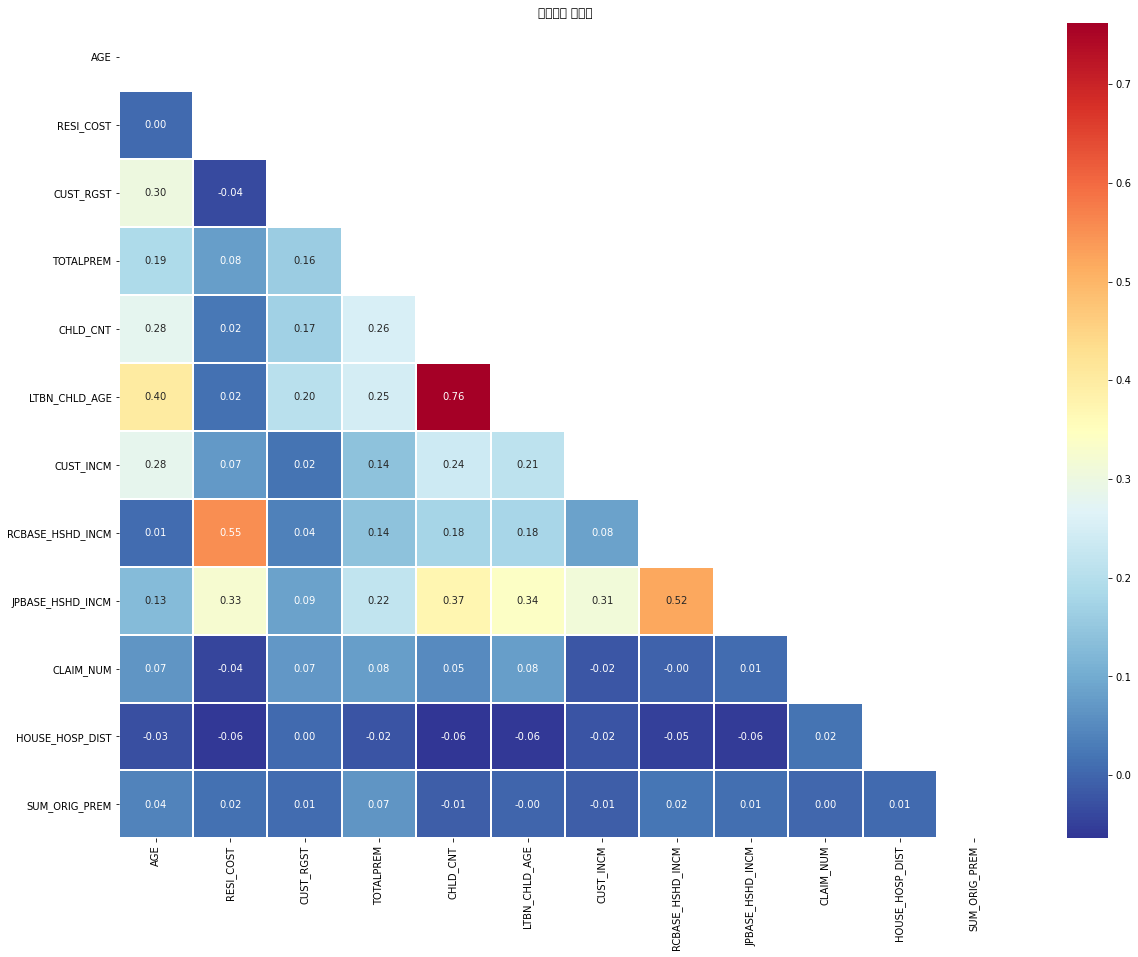

In [71]:
### 필요한 모듈 불러오기
#%matplotlib inline	# 시각화 결과를 Jupyter Notebook에서 바로 보기
# import matplotlib.pyplot as plt    # 모듈 불러오기

### 상관계수 테이블
corr = data.corr()    # 'df'라는 데이터셋을 'corr'라는 이름의 상관계수 테이블로 저장 

### 상관계수 히트맵 그리기

# 히트맵 사이즈 설정
plt.figure(figsize = (20, 15))	

# 히트맵 형태 정의. 여기서는 삼각형 형태(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
sns.heatmap(data = corr,    # 'corr' = 상관계수 테이블
            annot = True,  # 히트맵에 값 표시
            mask=mask,   # 히트맵 형태. 여기서는 위에서 정의한 삼각형 형태
            fmt = '.2f',   # 값 표시 방식. 소숫점 2번째자리까지 
            linewidths = 1.,  # 경계면 실선 구분 여부
            cmap = 'RdYlBu_r')  # 사용할 색 지정 ('python colormap 검색')
plt.title('상관계수 히트맵')
plt.show()

In [72]:
data = data[data.columns.difference(['LTBN_CHLD_AGE','JPBASE_HSHD_INCM'])]

# 3. 인코딩 및 정규화

##### 데이터 분리

In [73]:
col_1 = int_col(data)
col_2 = str_col(data)

['AGE', 'CHLD_CNT', 'CLAIM_NUM', 'CUST_INCM', 'CUST_RGST', 'HOUSE_HOSP_DIST', 'RCBASE_HSHD_INCM', 'RESI_COST', 'SUM_ORIG_PREM', 'TOTALPREM']
['ACCI_DVSN', 'CTPR', 'DMND_RESN_CODE', 'FP_CAREER', 'HEED_HOSP_YN', 'MAXCRDT', 'MINCRDT', 'OCCP_GRP_1', 'RESI_TYPE_CODE', 'SEX', 'WEDD_YN']


In [74]:
int_data = data[col_1]
str_data = data[col_2]

# 3 - 1 인코딩

##### 라벨링

In [75]:
label_data = str_data.copy()

for i in col_2:
    encoder = LabelEncoder()
    encoder.fit(label_data[i])
    label_data[i] = encoder.transform(label_data[i])
    print(label_data[i].unique())
    print(encoder.classes_)
    #print(encoder.inverse_transform([1, 0]))

[2 0 1]
['1' '2' '3']
[ 1  7 16 13  5  8  2 11  4 12  3  6 14  0 10 15  9]
['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']
[1 4 5 2 0 6 3 7]
['1' '2' '3' '4' '5' '6' '7' '9']
[0 1]
['N' 'Y']
[0 1]
['N' 'Y']
[6 8 7 9 1 4 3 2 0 5]
['1.0' '10.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0']
[6 0 5 7 2 8 4 3 1 9]
['1.0' '10.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0']
[7 2 0 3 5 4 1 6]
['1.주부' '2.자영업' '3.사무직' '4.전문직' '5.서비스' '6.제조업' '7.1차산업' '8.기타']
[3 9 5 0 2 1 4 6 8 7]
['11.0' '12.0' '13.0' '20.0' '30.0' '40.0' '50.0' '60.0' '70.0' '99.0']
[0 1]
['1' '2']
[1 0]
['N' 'Y']


##### 원-핫

In [76]:
onehot_data = pd.get_dummies(str_data)
onehot_data

,ACCI_DVSN_1,ACCI_DVSN_2,ACCI_DVSN_3,CTPR_강원,CTPR_경기,CTPR_경남,CTPR_경북,CTPR_광주,CTPR_대구,CTPR_대전,...,RESI_TYPE_CODE_30.0,RESI_TYPE_CODE_40.0,RESI_TYPE_CODE_50.0,RESI_TYPE_CODE_60.0,RESI_TYPE_CODE_70.0,RESI_TYPE_CODE_99.0,SEX_1,SEX_2,WEDD_YN_N,WEDD_YN_Y
14514,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
18075,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3209,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2688,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
8884,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11295,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
11978,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5393,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
860,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [77]:
onehot_data.isnull().sum()

ACCI_DVSN_1            0
ACCI_DVSN_2            0
ACCI_DVSN_3            0
CTPR_강원                0
CTPR_경기                0
                      ..
RESI_TYPE_CODE_99.0    0
SEX_1                  0
SEX_2                  0
WEDD_YN_N              0
WEDD_YN_Y              0
Length: 74, dtype: int64

# 3 - 2 정규화

In [78]:
# 인덱스 빼두기 
index = int_data.index

# MinMaxcaler 객체 생성
scaler = MinMaxScaler()

# MinMaxcaler로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(int_data)

data_scaled = scaler.transform(int_data)

# int_data.loc[:,:] = data_scaled

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
data_scaled = pd.DataFrame(data=data_scaled, columns=int_data.columns, index=index)

print('feature 들의 정규화 최소 값')
print(data_scaled.min())
print('\nfeature 들의 정규화 최대 값')
print(data_scaled.max())

feature 들의 정규화 최소 값
AGE                 0.0
CHLD_CNT            0.0
CLAIM_NUM           0.0
CUST_INCM           0.0
CUST_RGST           0.0
HOUSE_HOSP_DIST     0.0
RCBASE_HSHD_INCM    0.0
RESI_COST           0.0
SUM_ORIG_PREM       0.0
TOTALPREM           0.0
dtype: float64

feature 들의 정규화 최대 값
AGE                 1.0
CHLD_CNT            1.0
CLAIM_NUM           1.0
CUST_INCM           1.0
CUST_RGST           1.0
HOUSE_HOSP_DIST     1.0
RCBASE_HSHD_INCM    1.0
RESI_COST           1.0
SUM_ORIG_PREM       1.0
TOTALPREM           1.0
dtype: float64


# 3 - 3 데이터 concat

In [79]:
# onehot_data = onehot_data.reset_index()

# data_scaled = data_scaled.reset_index()

# concat_data = pd.merge(left = data_scaled , right = onehot_data, how = "left", on = 'index').set_index('index')

In [80]:
concat_data = pd.concat([data_scaled,onehot_data], axis=1)

concat_data_2 = pd.concat([data_scaled,label_data], axis=1)

# 4. 주요변수 추출

##### 한글깨짐 문제 해결

In [81]:
# import matplotlib as mat
# import matplotlib.font_manager as fonm

# font_list = [font.name for font in fonm.fontManager.ttflist]
# for f in font_list:
#     print(f"{f}.ttf")

# mat.rcParams['font.family'] = 'Hancom Gothic'

##### 라벨을 붙여서 확인해야함

In [82]:
f_extraction = pd.concat([concat_data, y_train], axis=1)

In [83]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(f_extraction[f_extraction.columns.drop('SIU_CUST_YN')], f_extraction['SIU_CUST_YN'], test_size=0.2, random_state=42)

In [84]:
# 원래 여기 데이터에는 검증 데이터를 넣어야함 Test 데이터 넣으면 안됨!
# 검증 데이터 넣어주어서 교차검증 해보도록하기


evals = [(x_test_2, y_test_2)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1,
                           max_depth=3)
# eval_metric넣어주면서 검증 데이터로 loss 측정할 때 사용할 metric 지정
xgb_wrapper.fit(x_train_2, y_train_2, early_stopping_rounds=200,
               eval_set=evals, eval_metric='logloss')

preds = xgb_wrapper.predict(x_test_2)
preds_proba = xgb_wrapper.predict_proba(x_test_2)[:, 1]
print(preds_proba[:10])

[0]	validation_0-logloss:0.62275
[1]	validation_0-logloss:0.56544
[2]	validation_0-logloss:0.51724
[3]	validation_0-logloss:0.47680
[4]	validation_0-logloss:0.44256
[5]	validation_0-logloss:0.41320
[6]	validation_0-logloss:0.38783
[7]	validation_0-logloss:0.36620
[8]	validation_0-logloss:0.34754
[9]	validation_0-logloss:0.33109
[10]	validation_0-logloss:0.31689
[11]	validation_0-logloss:0.30467
[12]	validation_0-logloss:0.29388
[13]	validation_0-logloss:0.28444
[14]	validation_0-logloss:0.27617
[15]	validation_0-logloss:0.26893
[16]	validation_0-logloss:0.26241
[17]	validation_0-logloss:0.25677
[18]	validation_0-logloss:0.25196
[19]	validation_0-logloss:0.24734
[20]	validation_0-logloss:0.24355
[21]	validation_0-logloss:0.24015
[22]	validation_0-logloss:0.23711
[23]	validation_0-logloss:0.23459
[24]	validation_0-logloss:0.23243
[25]	validation_0-logloss:0.23011
[26]	validation_0-logloss:0.22812
[27]	validation_0-logloss:0.22642
[28]	validation_0-logloss:0.22493
[29]	validation_0-loglos

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

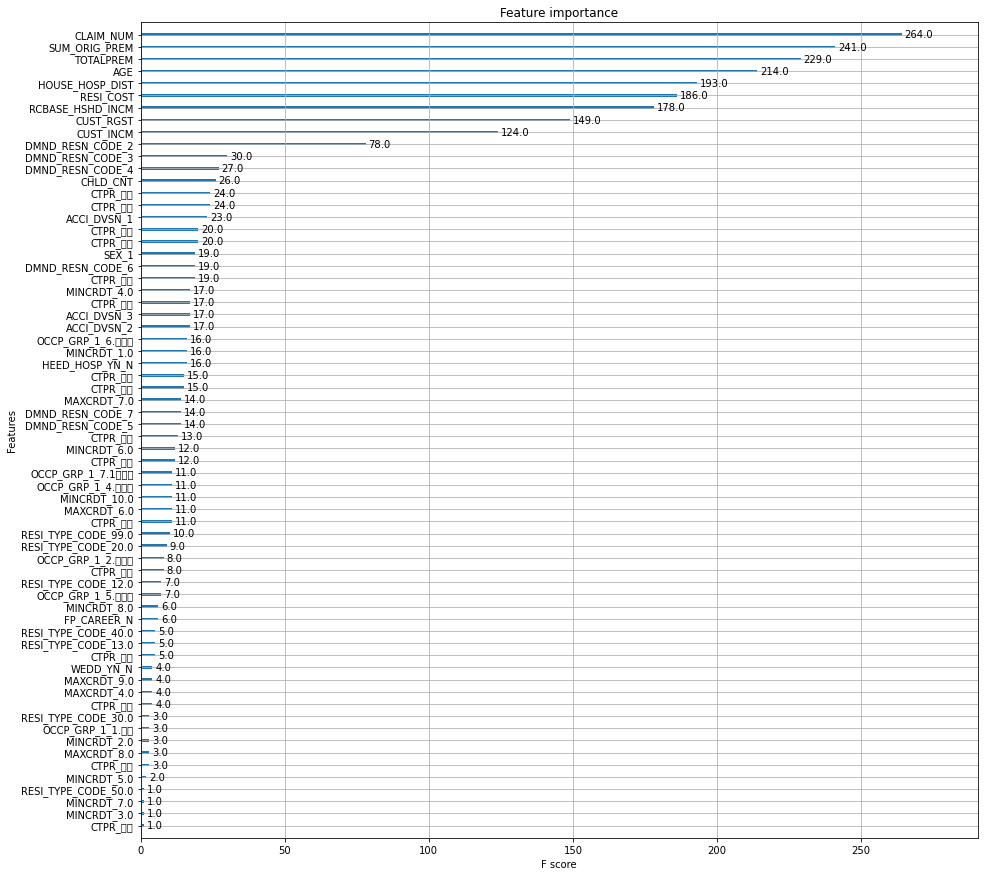

In [85]:
# feature별 중요도 시각화하기
fig, ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_wrapper, ax)

##### 필요한 컬럼만 추출

In [86]:
final_df = concat_data[['CHLD_CNT','SUM_ORIG_PREM','TOTALPREM','HOUSE_HOSP_DIST','RCBASE_HSHD_INCM','AGE','CUST_RGST','CLAIM_NUM','CUST_INCM',\
            'DMND_RESN_CODE_1', 'DMND_RESN_CODE_2','DMND_RESN_CODE_3', 'DMND_RESN_CODE_4', 'DMND_RESN_CODE_5','DMND_RESN_CODE_6',\
            'DMND_RESN_CODE_7', 'DMND_RESN_CODE_9','ACCI_DVSN_1', 'ACCI_DVSN_2', 'ACCI_DVSN_3','SEX_1', 'SEX_2']]

In [87]:
final_df

,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,CUST_INCM,DMND_RESN_CODE_1,...,DMND_RESN_CODE_4,DMND_RESN_CODE_5,DMND_RESN_CODE_6,DMND_RESN_CODE_7,DMND_RESN_CODE_9,ACCI_DVSN_1,ACCI_DVSN_2,ACCI_DVSN_3,SEX_1,SEX_2
14514,0.000000,1.320162e-03,0.000668,0.006727,0.156185,0.471264,0.220955,0.010309,0.000000,0,...,0,0,0,0,0,0,0,1,1,0
18075,0.333333,4.088642e-04,0.007527,0.015136,0.000000,0.540230,0.369030,0.000000,0.445889,0,...,0,1,0,0,0,0,0,1,1,0
3209,0.000000,7.153624e-04,0.008145,0.060840,0.000000,0.747126,0.369030,0.072165,0.000000,0,...,0,1,0,0,0,0,0,1,0,1
2688,0.166667,2.721696e-04,0.002133,0.048944,0.195118,0.459770,0.339845,0.000000,0.324348,0,...,0,0,1,0,0,0,0,1,0,1
8884,0.166667,7.808407e-04,0.002466,0.008738,0.273337,0.793103,0.369030,0.030928,0.267203,0,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11295,0.333333,1.293570e-03,0.000872,0.004427,0.271068,0.517241,0.455147,0.020619,0.333491,0,...,0,0,0,0,0,0,1,0,1,0
11978,0.000000,8.213272e-04,0.009956,0.006829,0.425538,0.689655,0.369030,0.030928,0.000000,0,...,0,0,1,0,0,0,0,1,0,1
5393,0.000000,1.136223e-03,0.002001,0.030682,0.262595,0.344828,0.369030,0.000000,0.264444,0,...,0,0,0,0,0,0,0,1,0,1
860,0.000000,9.996680e-08,0.003842,0.009034,0.497655,0.459770,0.369030,0.030928,0.372350,0,...,0,1,0,0,0,0,0,1,0,1


# 5. Clustering

# 5 - 1 분할적 군집화

##### 군집수인 k를 지정한 후 관측치들을 무작위로 k개의 집단으로 분할하고
##### 평균이나 최반값등을 이용하여 centroid(무게중심)를 수정해나가며 집단을 재분류하는 방법이다.

In [88]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##### 최적군집개수 구하기

In [89]:
# feature_data = concat_data.copy()

# X = feature_data.values ## 인덱스를 제외한 값을 ndarray로 추출
# distortions = []
# K = range(1,11)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

        
# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method Showing the optimal k')
# plt.show()

# for i in range(0,len(distortions)-1):
#     print(i+1,"번쨰 꺽이는 지점 : ",distortions[i] - distortions[i+1])

##### yellowbrick라는 패키지를 사용하면 더 알기 쉽게 알려준다

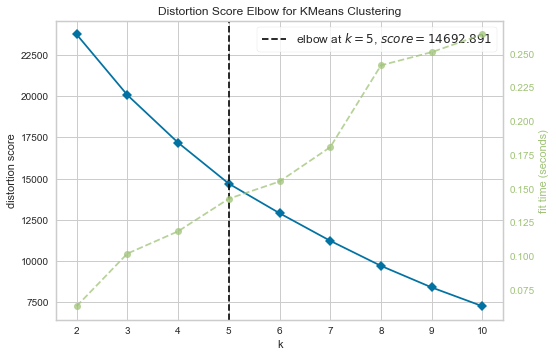

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
from yellowbrick.cluster import KElbowVisualizer

feature_data = final_df.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

##### 군집개수를 2 ~ 10까지 반복하면서 군집 결과를 확인함

In [93]:
# for i in range(2,11):
    
#     label_data = copy_data.copy()
#     feature_data = final_df.copy()
    
#     # 클러스터링 수 정의 
#     km = KMeans(n_clusters=i,init='k-means++', random_state=42)
#     km.fit(feature_data)

#     label_data['SIU_CUST_YN'] = label_data['SIU_CUST_YN'].replace('N',0)
#     label_data['SIU_CUST_YN'] = label_data['SIU_CUST_YN'].replace('Y',1)

#     feature_data['label'] = label_data['SIU_CUST_YN']

#     feature_data['cluster'] = km.labels_

#     cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()
#     print(i,"개로 군집화")
#     print(cluster_result) # groupby로 정답 분포 확인
    
#     # 차원축소
#     pca = PCA(n_components=2)
#     pca.fit(feature_data)
#     data_pca = pca.transform(feature_data)
    
#     print(i,"개로 군집화")
#     print(data_pca.shape)
#     print("설명력 : ",sum(pca.explained_variance_ratio_))

#     feature_data['pca_x'] = data_pca[:,0]
#     feature_data['pca_y'] = data_pca[:,1]
    
#     arr = [0 for n in range(i+1)]
#     base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
    
#     for j in range(0,i):
#         arr[j] = feature_data.loc[feature_data['cluster'] == j].index
        
#     arr[i] = feature_data.loc[feature_data['label'] == 1].index   
    
#     for j in range(0,len(arr)-1):
#         plt.scatter(x=feature_data.loc[arr[j],'pca_x'], y=feature_data.loc[arr[j],'pca_y'], color=base_color[j])
        
#     plt.scatter(x=feature_data.loc[arr[len(arr)-1],'pca_x'], y=feature_data.loc[arr[len(arr)-1],'pca_y'], color='lavender')
            
#     plt.xlabel('PCA 1')
#     plt.ylabel('PCA 2')
#     globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
#     plt.title(globals()['{}__cluster'.format(i)])
#     plt.show()        

##### 최적 군집개수로 3차원 그래프 생성

5 개로 군집화
label  cluster
0      0          3659
       1          2193
       2          5276
       3          3279
       4          2498
1      0           403
       1            73
       2           507
       3           332
       4           306
Name: AGE, dtype: int64
5 개로 군집화
(18526, 3)
설명력 :  0.7716197285957153


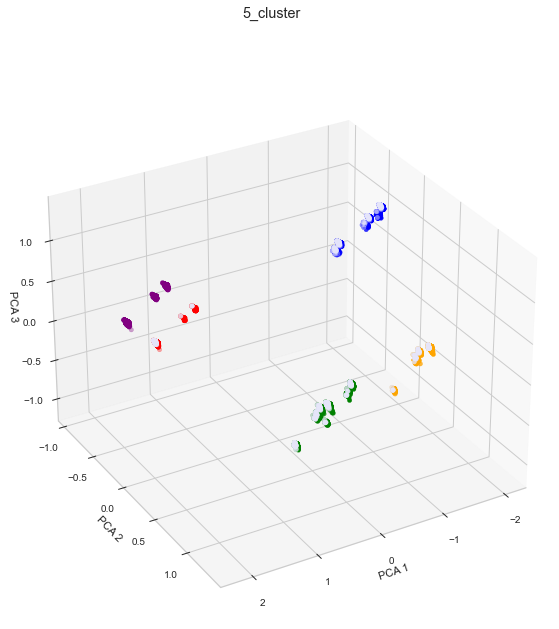

In [94]:
label_data = y_train.copy()
feature_data = final_df.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

pca = PCA(n_components=3)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]
feature_data['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

for j in range(0,i):
    arr[j] = feature_data.loc[feature_data['cluster'] == j].index
        
arr[i] = feature_data.loc[feature_data['label'] == 1].index

for j in range(0,len(arr)-1):
    ax.scatter(xs=feature_data.loc[arr[j],'pca_x'], ys=feature_data.loc[arr[j],'pca_y'], zs=feature_data.loc[arr[j],'pca_z'], c=base_color[j])

ax.scatter(xs=feature_data.loc[arr[len(arr)-1],'pca_x'], ys=feature_data.loc[arr[len(arr)-1],'pca_y'], zs=feature_data.loc[arr[len(arr)-1],'pca_z'], c='lavender')    

ax.view_init(30,60) # 0,60  / 0,0
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.suptitle(globals()['{}__cluster'.format(i)])
plt.show()        

In [95]:
p_100(403,3659)
p_100(73,2193) # 추출
p_100(507,5276)
p_100(332,3279)
p_100(306,2498)

9.92 %
3.22 %
8.77 %
9.19 %
10.91 %


#### 1번째 cluster 추출

In [96]:
result_data_N_0 = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 1].index ]

result_data_N_0.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_N = result_data_N_0.copy()

## 5 - 1 - 1        
- 2차 군집화 진행
- 총 5개의 군집 중 보험사기자의 비율이 5% 이상인 군집 4개를 2차 군집
- 0번째 cluster 2차 군집화 진행

In [97]:
blue_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 0].index ]

blue_data.drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1, inplace=True)

##### 최적군집개수 구하기

In [98]:
# orange_data_copy = orange_data.copy()

# X = orange_data_copy.values ## 인덱스를 제외한 값을 ndarray로 추출
# distortions = []
# K = range(1,11)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

        
# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method Showing the optimal k')
# plt.show()

# for i in range(0,len(distortions)-1):
#     print(i+1,"번쨰 꺽이는 지점 : ",distortions[i] - distortions[i+1])

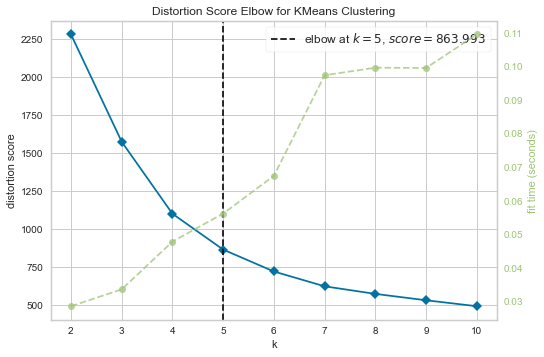

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = blue_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

##### 3차원으로 시각화 해보기

5 개로 군집화
label  cluster
0      0          1650
       1          1139
       2           406
       3           206
       4           258
1      0            54
       1           248
       2            35
       3            58
       4             8
Name: AGE, dtype: int64
5 개로 군집화
(4062, 3)
설명력 :  0.8853968002762831


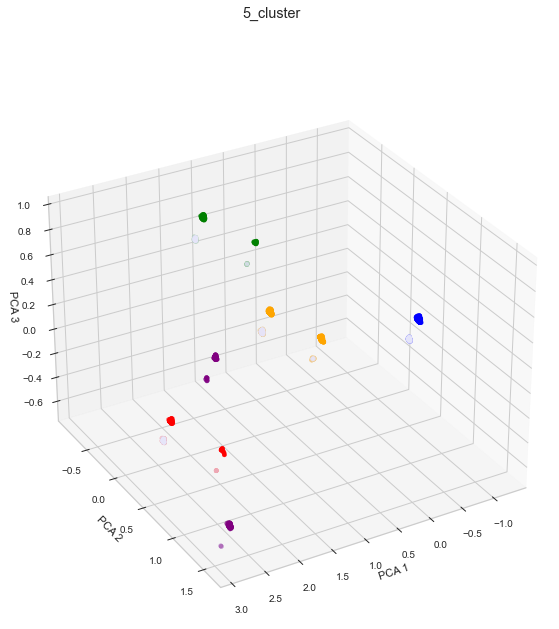

In [100]:
label_data = y_train.copy()
option_data_copy_1 = blue_data.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

pca = PCA(n_components=3)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]
option_data_copy_1['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index
        
arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index

for j in range(0,len(arr)-1):
    ax.scatter(xs=option_data_copy_1.loc[arr[j],'pca_x'], ys=option_data_copy_1.loc[arr[j],'pca_y'], zs=option_data_copy_1.loc[arr[j],'pca_z'], c=base_color[j])

ax.scatter(xs=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], ys=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], zs=option_data_copy_1.loc[arr[len(arr)-1],'pca_z'], c='lavender')    

ax.view_init(30,60) # 0,60  / 0,0
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.suptitle(globals()['{}__cluster'.format(i)])
plt.show()

5 개로 군집화
label  cluster
0      0          1650
       1          1139
       2           406
       3           206
       4           258
1      0            54
       1           248
       2            35
       3            58
       4             8
Name: AGE, dtype: int64
5 개로 군집화
(4062, 2)
설명력 :  0.8321485490901168


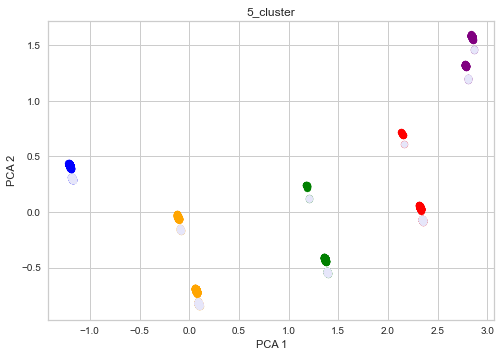

In [101]:
label_data = y_train.copy()
option_data_copy_1 = blue_data.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index

arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_1.loc[arr[j],'pca_x'], y=option_data_copy_1.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [102]:
p_100(54,1650) # 추출
p_100(248,1139)
p_100(35,406)
p_100(58,206)
p_100(8,258) # 추출

3.17 %
17.88 %
7.94 %
21.97 %
3.01 %


#### 0번 cluster와 4번 cluster result_data로 추출
- 더이상의 세부 군집화의 결과는 큰 의미가 없었음

In [103]:
result_data_N_1 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 0].index ]
result_data_N_1.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_N_2 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 4].index ]
result_data_N_2.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

temp = pd.concat([result_data_N_1, result_data_N_2], axis = 0)

result_data_N = pd.concat([result_data_N, temp], axis = 0)

#data.loc[result_data.index]

## 5 - 1 - 2       
- 2차 군집화 진행
- 총 5개의 군집 중 보험사기자의 비율이 5% 이상인 군집 4개를 2차 군집
- 2번째 cluster 2차 군집화 진행

In [104]:
label_data = y_train.copy()
feature_data = final_df.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인


pca = PCA(n_components=3)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)


feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]
feature_data['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']


5 개로 군집화
label  cluster
0      0          3659
       1          2193
       2          5276
       3          3279
       4          2498
1      0           403
       1            73
       2           507
       3           332
       4           306
Name: AGE, dtype: int64


In [105]:
green_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 2].index ]

green_data.drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1, inplace=True)

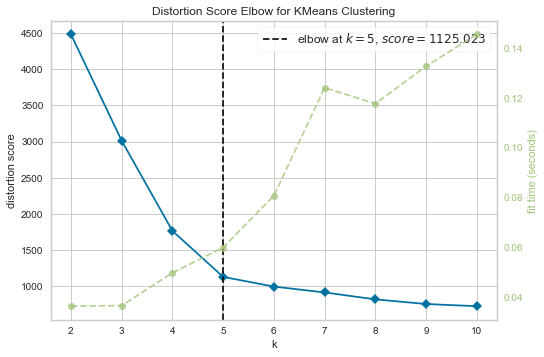

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = green_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

5 개로 군집화
label  cluster
0      0          1266
       1          1641
       2          1090
       3           762
       4           517
1      0           136
       1           144
       2            29
       3           131
       4            67
Name: AGE, dtype: int64
5 개로 군집화
(5783, 3)
설명력 :  0.8747576557588408


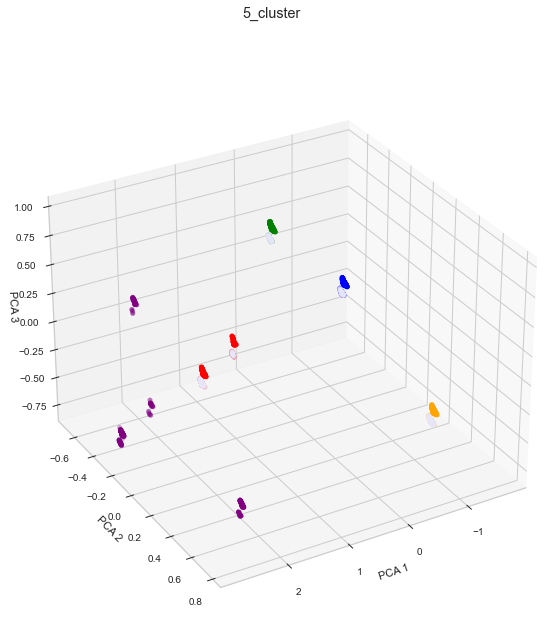

In [107]:
label_data = y_train.copy()
option_data_copy_1 = green_data.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

pca = PCA(n_components=3)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]
option_data_copy_1['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index
        
arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index

for j in range(0,len(arr)-1):
    ax.scatter(xs=option_data_copy_1.loc[arr[j],'pca_x'], ys=option_data_copy_1.loc[arr[j],'pca_y'], zs=option_data_copy_1.loc[arr[j],'pca_z'], c=base_color[j])

ax.scatter(xs=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], ys=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], zs=option_data_copy_1.loc[arr[len(arr)-1],'pca_z'], c='lavender')    

ax.view_init(30,60) # 0,60  / 0,0
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.suptitle(globals()['{}__cluster'.format(i)])
plt.show()

In [108]:
p_100(136,1266)
p_100(144,1641)
p_100(29,1090) # 추출
p_100(131,762)
p_100(67,517)

9.7 %
8.07 %
2.59 %
14.67 %
11.47 %


In [109]:
result_data_N_3 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 2].index ]

result_data_N_3.drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1, inplace=True)

result_data_N = pd.concat([result_data_N, result_data_N_3], axis = 0)

#### 3차군집화 진행

In [110]:
green_data_2 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 3].index ]

green_data_2.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

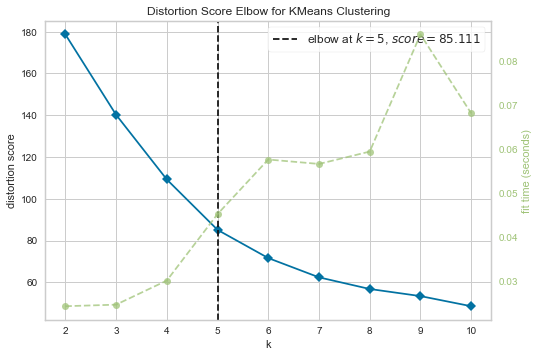

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [111]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = green_data_2.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

5 개로 군집화
label  cluster
0      0          488
       1           10
       2          206
       3           34
       4           24
1      0           86
       1           11
       2           34
Name: AGE, dtype: int64
5 개로 군집화
(893, 2)
설명력 :  0.8582726316829795


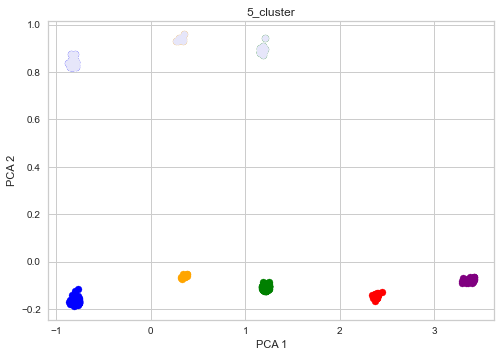

In [112]:
label_data = y_train.copy()
option_data_copy_2 = green_data_2.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_2)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_2['label'] = label_data

option_data_copy_2['cluster'] = km.labels_

cluster_result = option_data_copy_2.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_2)
data_pca = pca.transform(option_data_copy_2)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_2['pca_x'] = data_pca[:,0]
option_data_copy_2['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_2.loc[option_data_copy_2['cluster'] == j].index

arr[i] = option_data_copy_2.loc[option_data_copy_2['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_2.loc[arr[j],'pca_x'], y=option_data_copy_2.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_2.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_2.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

### 3번, 4번 cluster result_data로 추출
 - 더이상의 세부 군집화의 결과는 큰 의미가 없었음

In [113]:
result_data_N_4 = option_data_copy_2.loc[ option_data_copy_2.loc[option_data_copy_2['cluster'] == 3].index ]
result_data_N_4.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_N_5 = option_data_copy_2.loc[ option_data_copy_2.loc[option_data_copy_2['cluster'] == 4].index ]
result_data_N_5.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

temp = pd.concat([result_data_N_4, result_data_N_5], axis = 0)

result_data_N = pd.concat([result_data_N, temp], axis = 0)

## 5 - 1 - 3       
- 2차 군집화 진행
- 총 5개의 군집 중 보험사기자의 비율이 5% 이상인 군집 4개를 2차 군집
- 3번째 cluster 2차 군집화 진행

In [114]:
label_data = y_train.copy()
feature_data = final_df.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()

pca = PCA(n_components=3)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)


feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]
feature_data['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']


In [115]:
red_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 3].index ]

red_data.drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1, inplace=True)

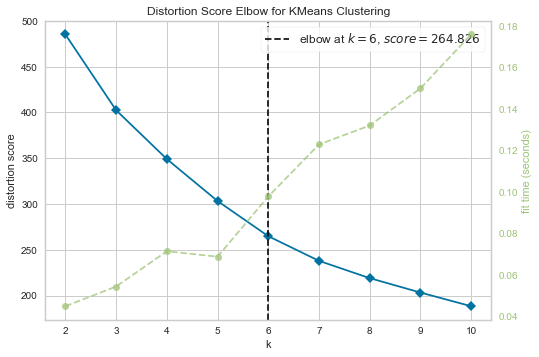

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [116]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = red_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

6 개로 군집화
label  cluster
0      0          1028
       1           104
       2           687
       3            27
       4           795
       5           638
1      0            76
       1             4
       2            75
       3             2
       4            92
       5            83
Name: AGE, dtype: int64
6 개로 군집화
(3611, 2)
설명력 :  0.956711963774274


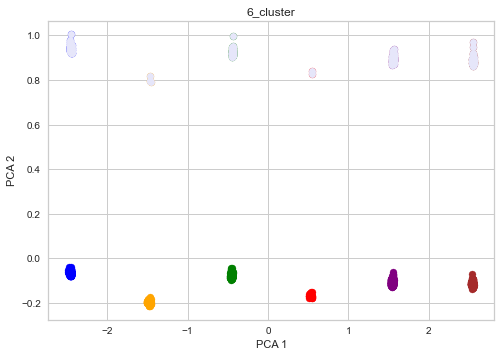

In [117]:
label_data = y_train.copy()
option_data_copy_1 = red_data.copy()

i = 6

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index

arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_1.loc[arr[j],'pca_x'], y=option_data_copy_1.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [118]:
p_100(76,1028)
p_100(4,104) # 추출
p_100(75,687) 
p_100(2,27)
p_100(92,795)
p_100(83,638)

6.88 %
3.7 %
9.84 %
6.9 %
10.37 %
11.51 %


#### 1번 cluster 추출

In [119]:
result_data_N_6 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 1].index ]
result_data_N_6.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_N = pd.concat([result_data_N, result_data_N_6], axis = 0)

#### 3차 군집화

In [120]:
red_data_2 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 0].index ]

red_data_2.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

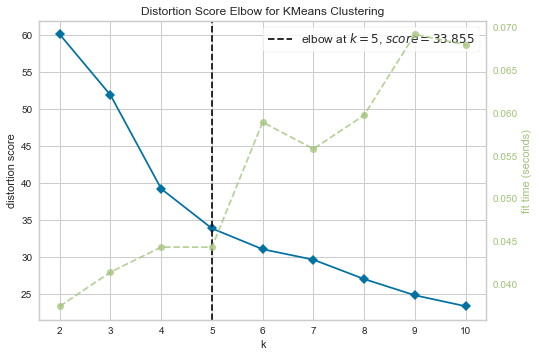

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [121]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = red_data_2.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

5 개로 군집화
label  cluster
0      0          212
       1          222
       2          307
       3           61
       4          226
1      0           19
       1           23
       2           14
       3            1
       4           19
Name: AGE, dtype: int64
5 개로 군집화
(1104, 2)
설명력 :  0.9719600324642763


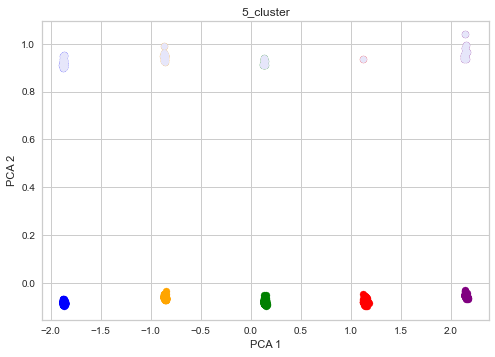

In [122]:
label_data = y_train.copy()
option_data_copy_2 = red_data_2.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_2)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_2['label'] = label_data

option_data_copy_2['cluster'] = km.labels_

cluster_result = option_data_copy_2.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_2)
data_pca = pca.transform(option_data_copy_2)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_2['pca_x'] = data_pca[:,0]
option_data_copy_2['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_2.loc[option_data_copy_2['cluster'] == j].index

arr[i] = option_data_copy_2.loc[option_data_copy_2['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_2.loc[arr[j],'pca_x'], y=option_data_copy_2.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_2.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_2.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [123]:
p_100(19,212)
p_100(23,222)
p_100(14,307) # 추출
p_100(1,61) # 추출
p_100(19,226)

8.23 %
9.39 %
4.36 %
1.61 %
7.76 %


### 2번, 3번 cluster result_data로 추출
 - 더이상의 세부 군집화의 결과는 큰 의미가 없었음

In [124]:
result_data_N_7 = option_data_copy_2.loc[ option_data_copy_2.loc[option_data_copy_2['cluster'] == 2].index ]
result_data_N_7.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_N_8 = option_data_copy_2.loc[ option_data_copy_2.loc[option_data_copy_2['cluster'] == 3].index ]
result_data_N_8.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

temp = pd.concat([result_data_N_7, result_data_N_8], axis = 0)

result_data_N = pd.concat([result_data_N, temp], axis = 0)

## 5 - 1 - 4       
- 2차 군집화 진행
- 총 5개의 군집 중 보험사기자의 비율이 5% 이상인 군집 4개를 2차 군집
- 4번째 cluster 2차 군집화 진행

In [125]:
label_data = y_train.copy()
feature_data = final_df.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()

pca = PCA(n_components=3)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)


feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]
feature_data['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']


In [126]:
purple_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 4].index ]

purple_data.drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1, inplace=True)

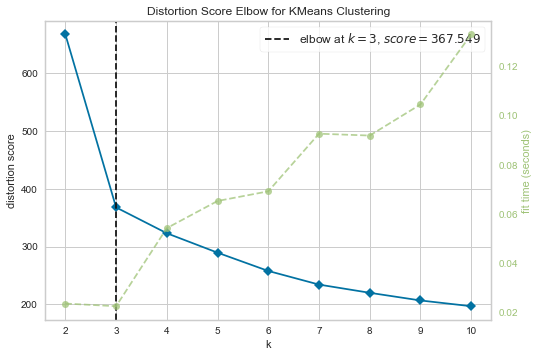

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [127]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = purple_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

3 개로 군집화
label  cluster
0      0          1560
       1           768
       2           170
1      0           272
       1            20
       2            14
Name: AGE, dtype: int64
3 개로 군집화
(2804, 2)
설명력 :  0.7954132879051934


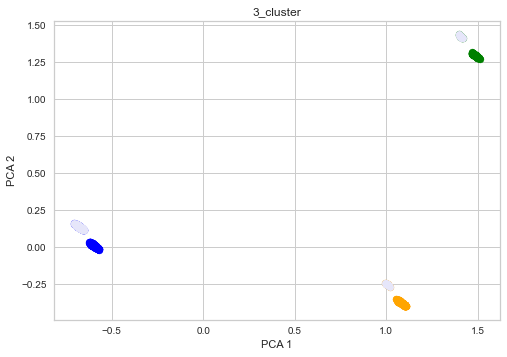

In [128]:
label_data = y_train.copy()
option_data_copy_1 = purple_data.copy()

i = 3

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index

arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_1.loc[arr[j],'pca_x'], y=option_data_copy_1.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [129]:
p_100(272,1560)
p_100(20,768) # 추출
p_100(14,170) 

14.85 %
2.54 %
7.61 %


#### 1번째 cluster 추출
 - 더이상의 군집은 의미없었음

In [130]:
result_data_N_9 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 1].index ]
result_data_N_9.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_N = pd.concat([result_data_N, result_data_N_9], axis = 0)

### label컬럼에서 Y가 5%미만으로 군집한 데이터 완성

In [131]:
result_data_N.drop(['pca_z'], axis=1, inplace = True)
result_data_N

,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,CUST_INCM,DMND_RESN_CODE_1,...,DMND_RESN_CODE_4,DMND_RESN_CODE_5,DMND_RESN_CODE_6,DMND_RESN_CODE_7,DMND_RESN_CODE_9,ACCI_DVSN_1,ACCI_DVSN_2,ACCI_DVSN_3,SEX_1,SEX_2
18893,0.0,0.000386,0.005793,0.005282,0.157799,0.356322,0.369030,0.051546,0.000000,0,...,0,0,1,0,0,1,0,0,1,0
19858,0.0,0.000501,0.003248,0.014317,0.490897,0.356322,0.369030,0.010309,0.000000,0,...,0,1,0,0,0,1,0,0,1,0
20437,0.0,0.000091,0.005793,0.002020,0.469867,0.195402,0.369030,0.020619,0.000000,0,...,0,0,1,0,0,0,1,0,1,0
8582,0.0,0.001730,0.029540,0.022876,0.493419,0.436782,0.245196,0.010309,0.375266,0,...,0,0,1,0,0,1,0,0,1,0
18897,0.0,0.001029,0.005793,0.004844,0.440113,0.241379,0.274300,0.020619,0.000000,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17267,0.0,0.000198,0.005793,0.003040,0.260023,0.172414,0.373894,0.010309,0.000000,0,...,0,0,1,0,0,1,0,0,0,1
15806,0.0,0.001205,0.005793,0.002296,0.260174,0.264368,0.255004,0.030928,0.000000,0,...,0,0,1,0,0,1,0,0,0,1
2613,0.0,0.000768,0.000135,0.009465,0.000000,0.379310,0.398134,0.051546,0.266414,0,...,0,0,1,0,0,1,0,0,0,1
3007,0.0,0.001840,0.205499,0.002467,0.126078,0.781609,0.475799,0.061856,0.365650,0,...,0,0,1,0,0,1,0,0,0,1


## 보험사기 여부가 N인 집단의 특성 확인하기¶

In [132]:
explain = result_data_N.columns

In [133]:
for i in range(0,9):
    print(" '(' ",explain[i]," ')'")
    print("전체 데이터")
    print(result_data_N[explain[i]].describe())
    print()
    print('--------------------')

 '('  CHLD_CNT  ')'
전체 데이터
count    6692.000000
mean        0.096209
std         0.148991
min         0.000000
25%         0.000000
50%         0.000000
75%         0.166667
max         0.833333
Name: CHLD_CNT, dtype: float64

--------------------
 '('  SUM_ORIG_PREM  ')'
전체 데이터
count    6.692000e+03
mean     1.699592e-03
std      1.038657e-02
min      9.996680e-08
25%      5.346437e-04
50%      9.329652e-04
75%      1.364692e-03
max      5.024048e-01
Name: SUM_ORIG_PREM, dtype: float64

--------------------
 '('  TOTALPREM  ')'
전체 데이터
count    6.692000e+03
mean     1.145425e-02
std      2.228973e-02
min      8.695408e-07
25%      4.804283e-03
50%      5.792802e-03
75%      1.094773e-02
max      1.000000e+00
Name: TOTALPREM, dtype: float64

--------------------
 '('  HOUSE_HOSP_DIST  ')'
전체 데이터
count    6692.000000
mean        0.046001
std         0.109296
min         0.000000
25%         0.004442
50%         0.009789
75%         0.027128
max         1.000000
Name: HOUSE_HOSP_DIST, dty

In [134]:
for i in range(9,len(explain)):
    print("'(' ",explain[i]," ')'")
    print(result_data_N[explain[0]].groupby(result_data_N[explain[i]]).count())
    print()
    print('--------------------')

'('  DMND_RESN_CODE_1  ')'
DMND_RESN_CODE_1
0    6650
1      42
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_2  ')'
DMND_RESN_CODE_2
0    6500
1     192
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_3  ')'
DMND_RESN_CODE_3
0    3359
1    3333
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_4  ')'
DMND_RESN_CODE_4
0    6681
1      11
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_5  ')'
DMND_RESN_CODE_5
0    5937
1     755
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_6  ')'
DMND_RESN_CODE_6
0    4377
1    2315
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_7  ')'
DMND_RESN_CODE_7
0    6649
1      43
Name: CHLD_CNT, dtype: int64

--------------------
'('  DMND_RESN_CODE_9  ')'
DMND_RESN_CODE_9
0    6691
1       1
Name: CHLD_CNT, dtype: int64

--------------------
'('  ACCI_DVSN_1  ')'
ACCI_DVSN_1
0    3644
1    3048
Name: CHLD_CNT, dtype: int

# 5 - 2 나머지 데이터로 재군집화를 통해 Y군집 데이터 추출

##### N군집을 제외하고 나머지 데이터프레임의 인덱스를 기준으로 추출

In [135]:
col = []
for i in x_train.index.to_list():
    if i not in result_data_N.index.to_list():    
        col.append(i)

data_2 = final_df.loc[col]

## data_2 군집화

##### 최적군집개수 확인

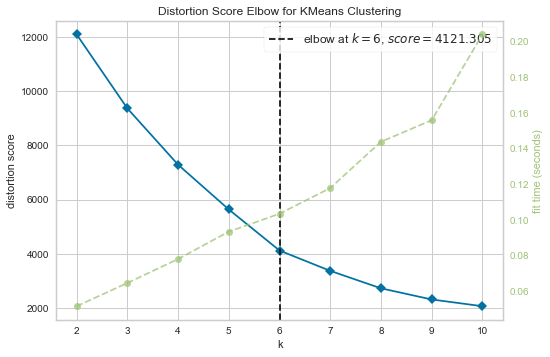

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [136]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = data_2.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

6 개로 군집화
label  cluster
0      0          1276
       1          2914
       2          1644
       3          1730
       4          1689
       5          1163
1      0           147
       1           321
       2           333
       3           286
       4           152
       5           179
Name: AGE, dtype: int64
6 개로 군집화
(11834, 2)
설명력 :  0.7436437345228655


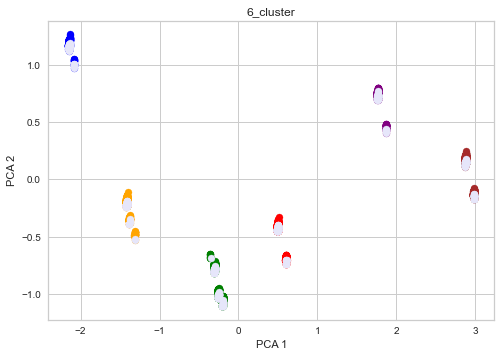

In [137]:
label_data = y_train.copy()
feature_data = data_2.copy()

i = 6

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = feature_data.loc[feature_data['cluster'] == j].index

arr[i] = feature_data.loc[feature_data['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=feature_data.loc[arr[j],'pca_x'], y=feature_data.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=feature_data.loc[arr[len(arr)-1],'pca_x'], y=feature_data.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [138]:
p_100(147,1276)
p_100(321,2914)
p_100(333,1644)
p_100(286,1730)
p_100(152,1689)
p_100(179,1163) 

10.33 %
9.92 %
16.84 %
14.19 %
8.26 %
13.34 %


## 5 - 2 - 1       
- 2차 군집화 진행
- 총 6개의 군집 중 보험사기자의 비율이 11% 초과인 군집 3개를 2차 군집
- 2번째 cluster 2차 군집화 진행

In [139]:
green_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 2].index ]

green_data.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

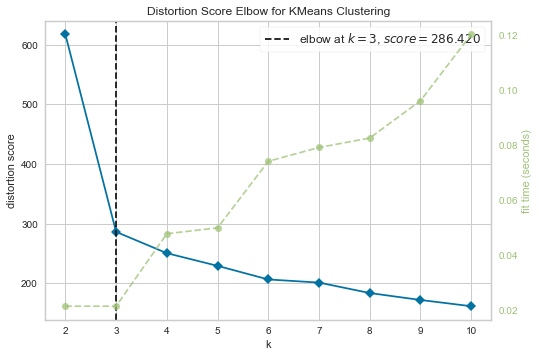

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [140]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = green_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

3 개로 군집화
label  cluster
0      0           206
       1          1032
       2           406
1      0            58
       1           240
       2            35
Name: AGE, dtype: int64
3 개로 군집화
(1977, 2)
설명력 :  0.7559386172356521


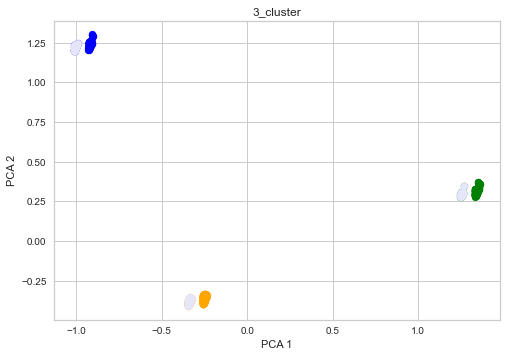

In [141]:
label_data = y_train.copy()
option_data_copy_1 = green_data.copy()

i = 3

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index

arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_1.loc[arr[j],'pca_x'], y=option_data_copy_1.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [142]:
p_100(58,206)
p_100(240,1032)
p_100(35,406) 

21.97 %
18.87 %
7.94 %


### 0번, 1번 cluster result_data_Y로 추출
 - 더이상의 세부 군집화의 결과는 큰 의미가 없었음

In [143]:
result_data_Y_0 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 0].index ]
result_data_Y_0.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_Y_1 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 1].index ]
result_data_Y_1.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_Y = pd.concat([result_data_Y_0, result_data_Y_1], axis = 0)

## 5 - 2 - 2       
- 2차 군집화 진행
- 총 6개의 군집 중 보험사기자의 비율이 15% 초과인 군집 3개를 2차 군집
- 3번째 cluster 2차 군집화 진행

In [144]:
label_data = y_train.copy()
feature_data = data_2.copy()

i = 6

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()

pca = PCA(n_components=3)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)


feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]
feature_data['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']


In [145]:
red_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 3].index ]

red_data.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

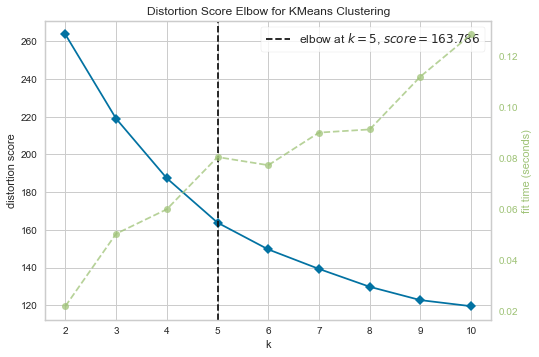

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [146]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = red_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

5 개로 군집화
label  cluster
0      0          170
       1          457
       2          377
       3          311
       4          415
1      0           14
       1           54
       2           86
       3           43
       4           89
Name: AGE, dtype: int64
5 개로 군집화
(2016, 2)
설명력 :  0.8933011125375522


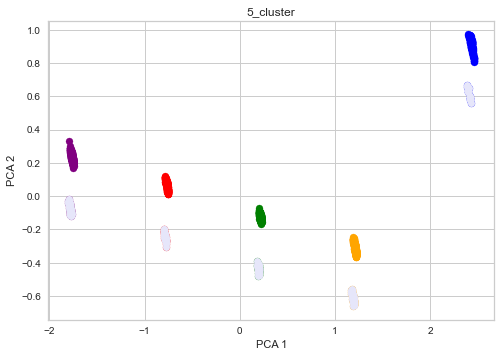

In [147]:
label_data = y_train.copy()
option_data_copy_1 = red_data.copy()

i = 5

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index

arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_1.loc[arr[j],'pca_x'], y=option_data_copy_1.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [148]:
p_100(14,170)
p_100(54,457)
p_100(86,377) # 추출
p_100(43,311)
p_100(89,415) # 추출 

7.61 %
10.57 %
18.57 %
12.15 %
17.66 %


### 2번, 4번 cluster result_data_Y로 추출
 - 더이상의 세부 군집화의 결과는 큰 의미가 없었음

In [149]:
result_data_Y_2 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 2].index ]
result_data_Y_2.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_Y_3 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 4].index ]
result_data_Y_3.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

temp = pd.concat([result_data_Y_2, result_data_Y_3], axis = 0)

result_data_Y = pd.concat([result_data_Y, temp], axis = 0)

## 5 - 2 - 3       
- 2차 군집화 진행
- 총 6개의 군집 중 보험사기자의 비율이 10% 초과인 군집 3개를 2차 군집
- 5번째 cluster 2차 군집화 진행

In [150]:
label_data = y_train.copy()
feature_data = data_2.copy()

i = 6

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(feature_data)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

feature_data['label'] = label_data

feature_data['cluster'] = km.labels_

cluster_result = feature_data.groupby(['label','cluster'])['AGE'].count()

pca = PCA(n_components=3)
pca.fit(feature_data)
data_pca = pca.transform(feature_data)


feature_data['pca_x'] = data_pca[:,0]
feature_data['pca_y'] = data_pca[:,1]
feature_data['pca_z'] = data_pca[:,2]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']


In [151]:
brown_data = feature_data.loc[ feature_data.loc[feature_data['cluster'] == 5].index ]

brown_data.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

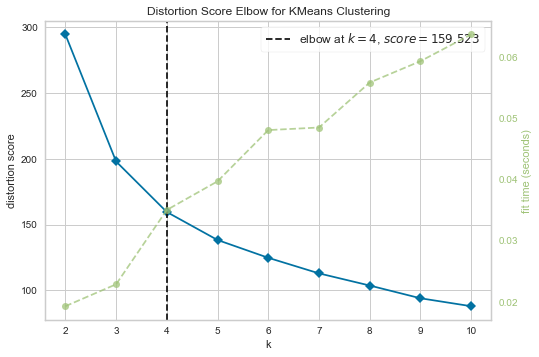

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [152]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
feature_data = brown_data.copy()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(feature_data)
visualizer.show()

4 개로 군집화
label  cluster
0      0          409
       1          206
       2           60
       3          488
1      0           51
       1           34
       2            8
       3           86
Name: AGE, dtype: int64
4 개로 군집화
(1342, 2)
설명력 :  0.8882869472368631


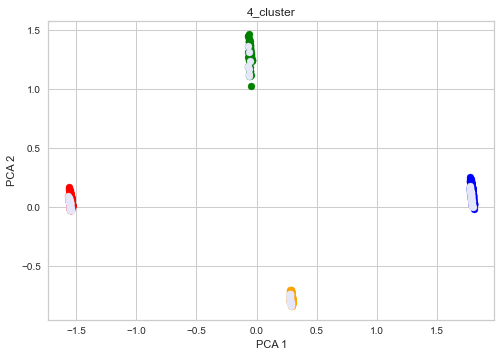

In [153]:
label_data = y_train.copy()
option_data_copy_1 = brown_data.copy()

i = 4

km = KMeans(n_clusters=i ,init='k-means++', random_state=42)
km.fit(option_data_copy_1)

label_data = label_data.replace('N',0)
label_data = label_data.replace('Y',1)

option_data_copy_1['label'] = label_data

option_data_copy_1['cluster'] = km.labels_

cluster_result = option_data_copy_1.groupby(['label','cluster'])['AGE'].count()
print(i,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인

# 차원축소
pca = PCA(n_components=2)
pca.fit(option_data_copy_1)
data_pca = pca.transform(option_data_copy_1)

print(i,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

option_data_copy_1['pca_x'] = data_pca[:,0]
option_data_copy_1['pca_y'] = data_pca[:,1]

arr = [0 for n in range(i+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

for j in range(0,i):
    arr[j] = option_data_copy_1.loc[option_data_copy_1['cluster'] == j].index

arr[i] = option_data_copy_1.loc[option_data_copy_1['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=option_data_copy_1.loc[arr[j],'pca_x'], y=option_data_copy_1.loc[arr[j],'pca_y'], color=base_color[j])

plt.scatter(x=option_data_copy_1.loc[arr[len(arr)-1],'pca_x'], y=option_data_copy_1.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(i)] = "{}_cluster".format(i)
plt.title(globals()['{}__cluster'.format(i)])
plt.show()   

In [154]:
p_100(51,409)
p_100(34,206) # 추출
p_100(8,60) 
p_100(86,488) # 추출

11.09 %
14.17 %
11.76 %
14.98 %


## 1번, 3번 cluster result_data_Y로 추출
 - 더이상의 세부 군집화의 결과는 큰 의미가 없었음

In [155]:
result_data_Y_4 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 1].index ]
result_data_Y_4.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

result_data_Y_5 = option_data_copy_1.loc[ option_data_copy_1.loc[option_data_copy_1['cluster'] == 3].index ]
result_data_Y_5.drop(['label','cluster','pca_x','pca_y'], axis=1, inplace=True)

temp = pd.concat([result_data_Y_4, result_data_Y_5], axis = 0)

result_data_Y = pd.concat([result_data_Y, temp], axis = 0)

In [156]:
result_data_Y

,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,CUST_INCM,DMND_RESN_CODE_1,...,DMND_RESN_CODE_5,DMND_RESN_CODE_6,DMND_RESN_CODE_7,DMND_RESN_CODE_9,ACCI_DVSN_1,ACCI_DVSN_2,ACCI_DVSN_3,SEX_1,SEX_2,pca_z
8309,0.166667,0.001346,0.015530,0.000517,0.452822,0.551724,0.597161,0.000000,0.303618,0,...,0,0,0,0,1,0,0,0,1,NaN
4616,0.000000,0.001293,0.006465,0.074048,0.085884,0.827586,0.369030,0.020619,0.286908,0,...,0,0,0,0,1,0,0,0,1,NaN
17690,0.000000,0.000151,0.005793,0.024005,0.000000,0.931034,0.455147,0.020619,0.000000,0,...,0,0,0,0,1,0,0,0,1,NaN
1153,0.000000,0.000634,0.001681,0.001488,0.235564,0.275862,0.429711,0.020619,0.000000,0,...,0,0,0,0,1,0,0,0,1,NaN
11795,0.000000,0.001662,0.046336,0.423030,0.287054,0.666667,0.968424,0.010309,0.000000,0,...,0,0,0,0,1,0,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19915,0.000000,0.000263,0.005793,0.013217,0.258258,0.643678,0.455147,0.123711,0.000000,0,...,0,0,0,0,0,0,1,1,0,0.289613
13895,0.333333,0.001912,0.003033,0.020548,0.253568,0.517241,0.369030,0.000000,0.364783,0,...,0,0,0,0,0,0,1,1,0,0.284850
19561,0.000000,0.001469,0.007527,0.064791,0.000000,0.482759,0.427239,0.030928,0.571136,0,...,0,0,0,0,0,0,1,1,0,0.298282
9923,0.000000,0.001317,0.018698,0.008840,0.254526,0.379310,0.339845,0.000000,0.282809,0,...,0,0,0,0,0,0,1,1,0,0.292956


## Y 15%를 초과하는 군집분석

In [157]:
explain = result_data_Y.columns

for i in range(0,9):
    print(" '(' ",explain[i]," ')'")
    print("전체 데이터")
    print(result_data_Y[explain[i]].describe())
    print()
    print('--------------------')

for i in range(9,len(explain)):
    print("'(' ",explain[i]," ')'")
    print(result_data_Y[explain[0]].groupby(result_data_Y[explain[i]]).count())
    print()
    print('--------------------')

 '('  CHLD_CNT  ')'
전체 데이터
count    3317.000000
mean        0.141594
std         0.166212
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: CHLD_CNT, dtype: float64

--------------------
 '('  SUM_ORIG_PREM  ')'
전체 데이터
count    3317.000000
mean        0.001700
std         0.010793
min         0.000000
25%         0.000513
50%         0.000861
75%         0.001328
max         0.500268
Name: SUM_ORIG_PREM, dtype: float64

--------------------
 '('  TOTALPREM  ')'
전체 데이터
count    3317.000000
mean        0.015632
std         0.024107
min         0.000008
25%         0.004468
50%         0.007527
75%         0.017270
max         0.276206
Name: TOTALPREM, dtype: float64

--------------------
 '('  HOUSE_HOSP_DIST  ')'
전체 데이터
count    3317.000000
mean        0.043442
std         0.097580
min         0.000043
25%         0.005929
50%         0.010148
75%         0.030229
max         0.995435
Name: HOUSE_HOSP_DIST, dtype: float64

---

## Y가 5% 미만인 군집 10개 각각의 특성을 분석하기

In [158]:
columns = ['CHLD_CNT', 'SUM_ORIG_PREM', 'TOTALPREM', 'HOUSE_HOSP_DIST',
       'RCBASE_HSHD_INCM', 'AGE', 'CUST_RGST', 'CLAIM_NUM', 'CUST_INCM']

In [159]:
re_result_data_N_0 = data.loc[result_data_N_0.index][columns]
re_result_data_N_1 = data.loc[result_data_N_1.index][columns]
re_result_data_N_2 = data.loc[result_data_N_2.index][columns]
re_result_data_N_3 = data.loc[result_data_N_3.index][columns]
re_result_data_N_4 = data.loc[result_data_N_4.index][columns]
re_result_data_N_5 = data.loc[result_data_N_5.index][columns]
re_result_data_N_6 = data.loc[result_data_N_6.index][columns]
re_result_data_N_7 = data.loc[result_data_N_7.index][columns]
re_result_data_N_8 = data.loc[result_data_N_8.index][columns]
re_result_data_N_9 = data.loc[result_data_N_9.index][columns]

In [160]:
label_data = y_train.copy()
label_data

result_data_N_real = pd.concat([final_df.loc[result_data_N.index], label_data.loc[result_data_N.index]] , axis=1)

print( len(result_data_N_real.loc[result_data_N_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_real.loc[result_data_N_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_real.loc[result_data_N_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_real))
print()

result_data_N_0_real = pd.concat([final_df.loc[result_data_N_0.index], label_data.loc[result_data_N_0.index]] , axis=1)

print( len(result_data_N_0_real.loc[result_data_N_0_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_0_real.loc[result_data_N_0_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_0_real.loc[result_data_N_0_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_0_real))
print()

result_data_N_1_real = pd.concat([final_df.loc[result_data_N_1.index], label_data.loc[result_data_N_1.index]] , axis=1)

print( len(result_data_N_1_real.loc[result_data_N_1_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_1_real.loc[result_data_N_1_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_1_real.loc[result_data_N_1_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_1_real))
print()

result_data_N_2_real = pd.concat([final_df.loc[result_data_N_2.index], label_data.loc[result_data_N_2.index]] , axis=1)

print( len(result_data_N_2_real.loc[result_data_N_2_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_2_real.loc[result_data_N_2_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_2_real.loc[result_data_N_2_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_2_real))
print()

result_data_N_3_real = pd.concat([final_df.loc[result_data_N_3.index], label_data.loc[result_data_N_3.index]] , axis=1)

print( len(result_data_N_3_real.loc[result_data_N_3_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_3_real.loc[result_data_N_3_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_3_real.loc[result_data_N_3_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_3_real))
print()

result_data_N_4_real = pd.concat([final_df.loc[result_data_N_4.index], label_data.loc[result_data_N_4.index]] , axis=1)

print( len(result_data_N_4_real.loc[result_data_N_4_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_4_real.loc[result_data_N_4_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_4_real.loc[result_data_N_4_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_4_real))
print()

result_data_N_5_real = pd.concat([final_df.loc[result_data_N_5.index], label_data.loc[result_data_N_5.index]] , axis=1)

print( len(result_data_N_5_real.loc[result_data_N_5_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_5_real.loc[result_data_N_5_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_5_real.loc[result_data_N_5_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_5_real))
print()

result_data_N_6_real = pd.concat([final_df.loc[result_data_N_6.index], label_data.loc[result_data_N_6.index]] , axis=1)

print( len(result_data_N_6_real.loc[result_data_N_6_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_6_real.loc[result_data_N_6_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_6_real.loc[result_data_N_6_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_6_real))
print()

result_data_N_7_real = pd.concat([final_df.loc[result_data_N_7.index], label_data.loc[result_data_N_7.index]] , axis=1)

print( len(result_data_N_7_real.loc[result_data_N_7_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_7_real.loc[result_data_N_7_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_7_real.loc[result_data_N_7_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_7_real))
print()

result_data_N_8_real = pd.concat([final_df.loc[result_data_N_8.index], label_data.loc[result_data_N_8.index]] , axis=1)

print( len(result_data_N_8_real.loc[result_data_N_8_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_8_real.loc[result_data_N_8_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_8_real.loc[result_data_N_8_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_8_real))
print()

result_data_N_9_real = pd.concat([final_df.loc[result_data_N_9.index], label_data.loc[result_data_N_9.index]] , axis=1)

print( len(result_data_N_9_real.loc[result_data_N_9_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_N_9_real.loc[result_data_N_9_real['SIU_CUST_YN'] == 'Y']) + len(result_data_N_9_real.loc[result_data_N_9_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_N_9_real))
print()

0.030334728033472803
전체 크기 :  6692

0.032215357458075904
전체 크기 :  2266

0.03169014084507042
전체 크기 :  1704

0.03007518796992481
전체 크기 :  266

0.025915996425379804
전체 크기 :  1119

0.0
전체 크기 :  34

0.0
전체 크기 :  24

0.037037037037037035
전체 크기 :  108

0.04361370716510903
전체 크기 :  321

0.016129032258064516
전체 크기 :  62

0.025380710659898477
전체 크기 :  788



In [161]:
explain = result_data_N_5.columns

# Y_list = [ 'result_data_Y_0','result_data_Y_1','result_data_Y_2','result_data_Y_3','result_data_Y_4','result_data_Y_5' ]
# N_list = [ 'result_data_0','result_data_1','result_data_2','result_data_3','result_data_4','result_data_5','result_data_6',\
#           'result_data_7','result_data_8','result_data_9' ]
summary_N_num = []
summary_N_RESN = []
summary_N_ACCI = []
summary_N_SEX = []

summary_N_num = [ pd.concat([ re_result_data_N_0[explain[0]].describe(), re_result_data_N_0[explain[1]].describe(), re_result_data_N_0[explain[2]].describe(),\
          re_result_data_N_0[explain[3]].describe(), re_result_data_N_0[explain[4]].describe(), re_result_data_N_0[explain[5]].describe(), re_result_data_N_0[explain[6]].describe(), \
          re_result_data_N_0[explain[7]].describe(), re_result_data_N_0[explain[8]].describe() ], axis=1) ,\
          pd.concat([ re_result_data_N_1[explain[0]].describe(), re_result_data_N_1[explain[1]].describe(), re_result_data_N_1[explain[2]].describe(),\
          re_result_data_N_1[explain[3]].describe(), re_result_data_N_1[explain[4]].describe(), re_result_data_N_1[explain[5]].describe(), re_result_data_N_1[explain[6]].describe(), \
          re_result_data_N_1[explain[7]].describe(), re_result_data_N_1[explain[8]].describe()], axis=1) ,\
          pd.concat([ re_result_data_N_2[explain[0]].describe(), re_result_data_N_2[explain[1]].describe(), re_result_data_N_2[explain[2]].describe(),\
          re_result_data_N_2[explain[3]].describe(), re_result_data_N_2[explain[4]].describe(), re_result_data_N_2[explain[5]].describe(), re_result_data_N_2[explain[6]].describe(), \
          re_result_data_N_2[explain[7]].describe(), re_result_data_N_2[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_3[explain[0]].describe(), re_result_data_N_3[explain[1]].describe(), re_result_data_N_3[explain[2]].describe(),\
          re_result_data_N_3[explain[3]].describe(), re_result_data_N_3[explain[4]].describe(), re_result_data_N_3[explain[5]].describe(), re_result_data_N_3[explain[6]].describe(), \
          re_result_data_N_3[explain[7]].describe(), re_result_data_N_3[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_4[explain[0]].describe(), re_result_data_N_4[explain[1]].describe(), re_result_data_N_4[explain[2]].describe(),\
          re_result_data_N_4[explain[3]].describe(), re_result_data_N_4[explain[4]].describe(), re_result_data_N_4[explain[5]].describe(), re_result_data_N_4[explain[6]].describe(), \
          re_result_data_N_4[explain[7]].describe(), re_result_data_N_4[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_5[explain[0]].describe(), re_result_data_N_5[explain[1]].describe(), re_result_data_N_5[explain[2]].describe(),\
          re_result_data_N_5[explain[3]].describe(), re_result_data_N_5[explain[4]].describe(), re_result_data_N_5[explain[5]].describe(), re_result_data_N_5[explain[6]].describe(), \
          re_result_data_N_5[explain[7]].describe(), re_result_data_N_5[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_6[explain[0]].describe(), re_result_data_N_6[explain[1]].describe(), re_result_data_N_6[explain[2]].describe(),\
          re_result_data_N_6[explain[3]].describe(), re_result_data_N_6[explain[4]].describe(), re_result_data_N_6[explain[5]].describe(), re_result_data_N_6[explain[6]].describe(), \
          re_result_data_N_6[explain[7]].describe(), re_result_data_N_6[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_7[explain[0]].describe(), re_result_data_N_7[explain[1]].describe(), re_result_data_N_7[explain[2]].describe(),\
          re_result_data_N_7[explain[3]].describe(), re_result_data_N_7[explain[4]].describe(), re_result_data_N_7[explain[5]].describe(), re_result_data_N_7[explain[6]].describe(), \
          re_result_data_N_7[explain[7]].describe(), re_result_data_N_7[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_8[explain[0]].describe(), re_result_data_N_8[explain[1]].describe(), re_result_data_N_8[explain[2]].describe(),\
          re_result_data_N_8[explain[3]].describe(), re_result_data_N_8[explain[4]].describe(), re_result_data_N_8[explain[5]].describe(), re_result_data_N_8[explain[6]].describe(), \
          re_result_data_N_8[explain[7]].describe(), re_result_data_N_8[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_N_9[explain[0]].describe(), re_result_data_N_9[explain[1]].describe(), re_result_data_N_9[explain[2]].describe(),\
          re_result_data_N_9[explain[3]].describe(), re_result_data_N_9[explain[4]].describe(), re_result_data_N_9[explain[5]].describe(), re_result_data_N_9[explain[6]].describe(), \
          re_result_data_N_9[explain[7]].describe(), re_result_data_N_9[explain[8]].describe()], axis=1) ]

summary_N_RESN = [ pd.concat([result_data_N_0[explain[9]].groupby(result_data_N_0[explain[9]]).count(), result_data_N_0[explain[10]].groupby(result_data_N_0[explain[10]]).count(),\
           result_data_N_0[explain[11]].groupby(result_data_N_0[explain[11]]).count(), result_data_N_0[explain[12]].groupby(result_data_N_0[explain[12]]).count(),\
           result_data_N_0[explain[13]].groupby(result_data_N_0[explain[13]]).count(), result_data_N_0[explain[14]].groupby(result_data_N_0[explain[14]]).count(),\
          result_data_N_0[explain[15]].groupby(result_data_N_0[explain[15]]).count(), result_data_N_0[explain[16]].groupby(result_data_N_0[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_N_1[explain[9]].groupby(result_data_N_1[explain[9]]).count(), result_data_N_1[explain[10]].groupby(result_data_N_1[explain[10]]).count(),\
           result_data_N_1[explain[11]].groupby(result_data_N_1[explain[11]]).count(), result_data_N_1[explain[12]].groupby(result_data_N_1[explain[12]]).count(),\
           result_data_N_1[explain[13]].groupby(result_data_N_1[explain[13]]).count(), result_data_N_1[explain[14]].groupby(result_data_N_1[explain[14]]).count(),\
          result_data_N_1[explain[15]].groupby(result_data_N_1[explain[15]]).count(), result_data_N_1[explain[16]].groupby(result_data_N_1[explain[16]]).count()], axis=1) ,\
           pd.concat([result_data_N_2[explain[9]].groupby(result_data_N_2[explain[9]]).count(), result_data_N_2[explain[10]].groupby(result_data_N_2[explain[10]]).count(),\
           result_data_N_2[explain[11]].groupby(result_data_N_2[explain[11]]).count(), result_data_N_2[explain[12]].groupby(result_data_N_2[explain[12]]).count(),\
           result_data_N_2[explain[13]].groupby(result_data_N_2[explain[13]]).count(), result_data_N_2[explain[14]].groupby(result_data_N_2[explain[14]]).count(),\
          result_data_N_2[explain[15]].groupby(result_data_N_2[explain[15]]).count(), result_data_N_2[explain[16]].groupby(result_data_N_2[explain[16]]).count()], axis=1) ,\
           pd.concat([result_data_N_3[explain[9]].groupby(result_data_N_3[explain[9]]).count(), result_data_N_3[explain[10]].groupby(result_data_N_3[explain[10]]).count(),\
           result_data_N_3[explain[11]].groupby(result_data_N_3[explain[11]]).count(), result_data_N_3[explain[12]].groupby(result_data_N_3[explain[12]]).count(),\
           result_data_N_3[explain[13]].groupby(result_data_N_3[explain[13]]).count(), result_data_N_3[explain[14]].groupby(result_data_N_3[explain[14]]).count(),\
          result_data_N_3[explain[15]].groupby(result_data_N_3[explain[15]]).count(), result_data_N_3[explain[16]].groupby(result_data_N_3[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_N_4[explain[9]].groupby(result_data_N_4[explain[9]]).count(), result_data_N_4[explain[10]].groupby(result_data_N_4[explain[10]]).count(),\
           result_data_N_4[explain[11]].groupby(result_data_N_4[explain[11]]).count(), result_data_N_4[explain[12]].groupby(result_data_N_4[explain[12]]).count(),\
           result_data_N_4[explain[13]].groupby(result_data_N_4[explain[13]]).count(), result_data_N_4[explain[14]].groupby(result_data_N_4[explain[14]]).count(),\
          result_data_N_4[explain[15]].groupby(result_data_N_4[explain[15]]).count(), result_data_N_4[explain[16]].groupby(result_data_N_4[explain[16]]).count()], axis=1) ,\
           pd.concat([result_data_N_5[explain[9]].groupby(result_data_N_5[explain[9]]).count(), result_data_N_5[explain[10]].groupby(result_data_N_5[explain[10]]).count(),\
           result_data_N_5[explain[11]].groupby(result_data_N_5[explain[11]]).count(), result_data_N_5[explain[12]].groupby(result_data_N_5[explain[12]]).count(),\
           result_data_N_5[explain[13]].groupby(result_data_N_5[explain[13]]).count(), result_data_N_5[explain[14]].groupby(result_data_N_5[explain[14]]).count(),\
          result_data_N_5[explain[15]].groupby(result_data_N_5[explain[15]]).count(), result_data_N_5[explain[16]].groupby(result_data_N_5[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_N_6[explain[9]].groupby(result_data_N_6[explain[9]]).count(), result_data_N_6[explain[10]].groupby(result_data_N_6[explain[10]]).count(),\
           result_data_N_6[explain[11]].groupby(result_data_N_6[explain[11]]).count(), result_data_N_6[explain[12]].groupby(result_data_N_6[explain[12]]).count(),\
           result_data_N_6[explain[13]].groupby(result_data_N_6[explain[13]]).count(), result_data_N_6[explain[14]].groupby(result_data_N_6[explain[14]]).count(),\
          result_data_N_6[explain[15]].groupby(result_data_N_6[explain[15]]).count(), result_data_N_6[explain[16]].groupby(result_data_N_6[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_N_7[explain[9]].groupby(result_data_N_7[explain[9]]).count(), result_data_N_7[explain[10]].groupby(result_data_N_7[explain[10]]).count(),\
           result_data_N_7[explain[11]].groupby(result_data_N_7[explain[11]]).count(), result_data_N_7[explain[12]].groupby(result_data_N_7[explain[12]]).count(),\
           result_data_N_7[explain[13]].groupby(result_data_N_7[explain[13]]).count(), result_data_N_7[explain[14]].groupby(result_data_N_7[explain[14]]).count(),\
           result_data_N_7[explain[15]].groupby(result_data_N_7[explain[15]]).count(), result_data_N_7[explain[16]].groupby(result_data_N_7[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_N_8[explain[9]].groupby(result_data_N_8[explain[9]]).count(), result_data_N_8[explain[10]].groupby(result_data_N_8[explain[10]]).count(),\
           result_data_N_8[explain[11]].groupby(result_data_N_8[explain[11]]).count(), result_data_N_8[explain[12]].groupby(result_data_N_8[explain[12]]).count(),\
           result_data_N_8[explain[13]].groupby(result_data_N_8[explain[13]]).count(), result_data_N_8[explain[14]].groupby(result_data_N_8[explain[14]]).count(),\
          result_data_N_8[explain[15]].groupby(result_data_N_8[explain[15]]).count(), result_data_N_8[explain[16]].groupby(result_data_N_8[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_N_9[explain[9]].groupby(result_data_N_9[explain[9]]).count(), result_data_N_9[explain[10]].groupby(result_data_N_9[explain[10]]).count(),\
           result_data_N_9[explain[11]].groupby(result_data_N_9[explain[11]]).count(), result_data_N_9[explain[12]].groupby(result_data_N_9[explain[12]]).count(),\
           result_data_N_9[explain[13]].groupby(result_data_N_9[explain[13]]).count(), result_data_N_9[explain[14]].groupby(result_data_N_9[explain[14]]).count(),\
          result_data_N_9[explain[15]].groupby(result_data_N_9[explain[15]]).count(), result_data_N_9[explain[16]].groupby(result_data_N_9[explain[16]]).count()], axis=1) ]


summary_N_ACCI = [ pd.concat([result_data_N_0[explain[17]].groupby(result_data_N_0[explain[17]]).count(), result_data_N_0[explain[18]].groupby(result_data_N_0[explain[18]]).count(),\
           result_data_N_0[explain[19]].groupby(result_data_N_0[explain[19]]).count()], axis=1) ,\
             pd.concat([result_data_N_1[explain[17]].groupby(result_data_N_1[explain[17]]).count(), result_data_N_1[explain[18]].groupby(result_data_N_1[explain[18]]).count(),\
           result_data_N_1[explain[19]].groupby(result_data_N_1[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_2[explain[17]].groupby(result_data_N_2[explain[17]]).count(), result_data_N_2[explain[18]].groupby(result_data_N_2[explain[18]]).count(),\
           result_data_N_2[explain[19]].groupby(result_data_N_2[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_3[explain[17]].groupby(result_data_N_3[explain[17]]).count(), result_data_N_3[explain[18]].groupby(result_data_N_3[explain[18]]).count(),\
           result_data_N_3[explain[19]].groupby(result_data_N_3[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_4[explain[17]].groupby(result_data_N_4[explain[17]]).count(), result_data_N_4[explain[18]].groupby(result_data_N_4[explain[18]]).count(),\
           result_data_N_4[explain[19]].groupby(result_data_N_4[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_5[explain[17]].groupby(result_data_N_5[explain[17]]).count(), result_data_N_5[explain[18]].groupby(result_data_N_5[explain[18]]).count(),\
           result_data_N_5[explain[19]].groupby(result_data_N_5[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_6[explain[17]].groupby(result_data_N_6[explain[17]]).count(), result_data_N_6[explain[18]].groupby(result_data_N_6[explain[18]]).count(),\
           result_data_N_6[explain[19]].groupby(result_data_N_6[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_7[explain[17]].groupby(result_data_N_7[explain[17]]).count(), result_data_N_7[explain[18]].groupby(result_data_N_7[explain[18]]).count(),\
           result_data_N_7[explain[19]].groupby(result_data_N_7[explain[19]]).count()], axis=1) ,\
          pd.concat([result_data_N_8[explain[17]].groupby(result_data_N_8[explain[17]]).count(), result_data_N_8[explain[18]].groupby(result_data_N_8[explain[18]]).count(),\
           result_data_N_8[explain[19]].groupby(result_data_N_8[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_N_9[explain[17]].groupby(result_data_N_9[explain[17]]).count(), result_data_N_9[explain[18]].groupby(result_data_N_9[explain[18]]).count(),\
           result_data_N_9[explain[19]].groupby(result_data_N_9[explain[19]]).count()], axis=1) ]

summary_N_SEX = [ pd.concat([result_data_N_0[explain[20]].groupby(result_data_N_0[explain[20]]).count(), \
                             result_data_N_0[explain[21]].groupby(result_data_N_0[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_1[explain[20]].groupby(result_data_N_1[explain[20]]).count(), \
                             result_data_N_1[explain[21]].groupby(result_data_N_1[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_2[explain[20]].groupby(result_data_N_2[explain[20]]).count(), \
                             result_data_N_2[explain[21]].groupby(result_data_N_2[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_3[explain[20]].groupby(result_data_N_3[explain[20]]).count(), \
                             result_data_N_3[explain[21]].groupby(result_data_N_3[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_4[explain[20]].groupby(result_data_N_4[explain[20]]).count(), \
                             result_data_N_4[explain[21]].groupby(result_data_N_4[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_5[explain[20]].groupby(result_data_N_5[explain[20]]).count(), \
                             result_data_N_5[explain[21]].groupby(result_data_N_5[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_6[explain[20]].groupby(result_data_N_6[explain[20]]).count(), \
                             result_data_N_6[explain[21]].groupby(result_data_N_6[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_7[explain[20]].groupby(result_data_N_7[explain[20]]).count(), \
                             result_data_N_7[explain[21]].groupby(result_data_N_7[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_8[explain[20]].groupby(result_data_N_8[explain[20]]).count(), \
                             result_data_N_8[explain[21]].groupby(result_data_N_8[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_N_9[explain[20]].groupby(result_data_N_9[explain[20]]).count(), \
                             result_data_N_9[explain[21]].groupby(result_data_N_9[explain[21]]).count()], axis=1) ]

In [162]:
# pandas 지수표현 없애기
pd.options.display.float_format = '{:.5f}'.format
# pandas 지수표현 되돌리기
# pd.reset_option('display.float_format')

In [163]:
for i, pan in enumerate(summary_N_num):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
        CHLD_CNT  SUM_ORIG_PREM       TOTALPREM  HOUSE_HOSP_DIST  \
count 2266.00000     2266.00000      2266.00000       2266.00000   
mean     0.48455   170909.86253  17386070.72043         22.65304   
std      0.86531   448776.82264  24583535.13960         50.58456   
min      0.00000      350.00000      2100.00000          0.00000   
25%      0.00000    53112.50000  10659556.00000          2.13200   
50%      0.00000    98735.00000  10659556.00000          4.54000   
75%      1.00000   145920.12500  16877142.00000         13.50958   
max      4.00000 10100185.00000 429434863.00000        400.52000   

       RCBASE_HSHD_INCM        AGE  CUST_RGST  CLAIM_NUM   CUST_INCM  
count        2266.00000 2266.00000 2266.00000 2266.00000  2266.00000  
mean         4636.74669   37.25110 4446.86981    3.79214  2713.07877  
std          2916.29492   15.47948 1043.10259    3.50094  2284.48884  
min             0.00000    5.00000  213.00000    1.00000     0.00000  
25%          2993.00000   23.0

In [164]:
for i, pan in enumerate(summary_N_RESN):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
   DMND_RESN_CODE_1  DMND_RESN_CODE_2  DMND_RESN_CODE_3  DMND_RESN_CODE_4  \
0              2258              2074              2022              2255   
1                 8               192               244                11   

   DMND_RESN_CODE_5  DMND_RESN_CODE_6  DMND_RESN_CODE_7  DMND_RESN_CODE_9  
0              2002               739              2247              2265  
1               264              1527                19                 1  
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

1
   DMND_RESN_CODE_1  DMND_RESN_CODE_2  DMND_RESN_CODE_3  DMND_RESN_CODE_4  \
0        1704.00000        1704.00000               NaN        1704.00000   
1               NaN               NaN        1704.00000               NaN   

   DMND_RESN_CODE_5  DMND_RESN_CODE_6  DMND_RESN_CODE_7  DMND_RESN_CODE_9  
0        1704.00000        1704.00000        1704.00000      

In [165]:
for i, pan in enumerate(summary_N_ACCI):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0          319         1947   2266.00000
1         1947          319          NaN
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

1
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0   1704.00000   1704.00000          NaN
1          NaN          NaN   1704.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

2
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0           61          205    266.00000
1          205           61          NaN
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

3
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0   1119.00000   1119.00000          NaN
1          NaN          NaN   1119.00000

In [166]:
for i, pan in enumerate(summary_N_SEX):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
       SEX_1      SEX_2
0        NaN 2266.00000
1 2266.00000        NaN
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

1
       SEX_1      SEX_2
0 1704.00000        NaN
1        NaN 1704.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

2
      SEX_1     SEX_2
0 266.00000       NaN
1       NaN 266.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

3
       SEX_1      SEX_2
0        NaN 1119.00000
1 1119.00000        NaN
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

4
     SEX_1    SEX_2
0      NaN 34.00000


## Y가 15% 초과인 군집 6개 각각의 특성을 분석하기

In [167]:
columns = ['CHLD_CNT', 'SUM_ORIG_PREM', 'TOTALPREM', 'HOUSE_HOSP_DIST',
       'RCBASE_HSHD_INCM', 'AGE', 'CUST_RGST', 'CLAIM_NUM', 'CUST_INCM']

In [168]:
re_result_data_Y_0 = data.loc[result_data_Y_0.index][columns]
re_result_data_Y_1 = data.loc[result_data_Y_1.index][columns]
re_result_data_Y_2 = data.loc[result_data_Y_2.index][columns]
re_result_data_Y_3 = data.loc[result_data_Y_3.index][columns]
re_result_data_Y_4 = data.loc[result_data_Y_4.index][columns]
re_result_data_Y_5 = data.loc[result_data_Y_5.index][columns]

In [169]:
label_data = y_train.copy()
label_data

result_data_Y_real = pd.concat([final_df.loc[result_data_Y.index], label_data.loc[result_data_Y.index]] , axis=1)

print( len(result_data_Y_real.loc[result_data_Y_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_real.loc[result_data_Y_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_real.loc[result_data_Y_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_real))
print()

result_data_Y_0_real = pd.concat([final_df.loc[result_data_Y_0.index], label_data.loc[result_data_Y_0.index]] , axis=1)

print( len(result_data_Y_0_real.loc[result_data_Y_0_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_0_real.loc[result_data_Y_0_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_0_real.loc[result_data_Y_0_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_0_real))
print()

result_data_Y_1_real = pd.concat([final_df.loc[result_data_Y_1.index], label_data.loc[result_data_Y_1.index]] , axis=1)

print( len(result_data_Y_1_real.loc[result_data_Y_1_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_1_real.loc[result_data_Y_1_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_1_real.loc[result_data_Y_1_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_1_real))
print()

result_data_Y_2_real = pd.concat([final_df.loc[result_data_Y_2.index], label_data.loc[result_data_Y_2.index]] , axis=1)

print( len(result_data_Y_2_real.loc[result_data_Y_2_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_2_real.loc[result_data_Y_2_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_2_real.loc[result_data_Y_2_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_2_real))
print()

result_data_Y_3_real = pd.concat([final_df.loc[result_data_Y_3.index], label_data.loc[result_data_Y_3.index]] , axis=1)

print( len(result_data_Y_3_real.loc[result_data_Y_3_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_3_real.loc[result_data_Y_3_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_3_real.loc[result_data_Y_3_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_3_real))
print()

result_data_Y_4_real = pd.concat([final_df.loc[result_data_Y_4.index], label_data.loc[result_data_Y_4.index]] , axis=1)

print( len(result_data_Y_4_real.loc[result_data_Y_4_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_4_real.loc[result_data_Y_4_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_4_real.loc[result_data_Y_4_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_4_real))
print()

result_data_Y_5_real = pd.concat([final_df.loc[result_data_Y_5.index], label_data.loc[result_data_Y_5.index]] , axis=1)

print( len(result_data_Y_5_real.loc[result_data_Y_5_real['SIU_CUST_YN'] == 'Y']) / \
      ( len(result_data_Y_5_real.loc[result_data_Y_5_real['SIU_CUST_YN'] == 'Y']) + len(result_data_Y_5_real.loc[result_data_Y_5_real['SIU_CUST_YN'] == 'N']) ))
print("전체 크기 : ",len(result_data_Y_5_real))
print()

0.1787760024118179
전체 크기 :  3317

0.2196969696969697
전체 크기 :  264

0.18867924528301888
전체 크기 :  1272

0.1857451403887689
전체 크기 :  463

0.1765873015873016
전체 크기 :  504

0.14166666666666666
전체 크기 :  240

0.14982578397212543
전체 크기 :  574



In [170]:
explain = result_data_Y_5.columns

# Y_list = [ 'result_data_Y_0','result_data_Y_1','result_data_Y_2','result_data_Y_3','result_data_Y_4','result_data_Y_5' ]
# N_list = [ 'result_data_0','result_data_1','result_data_2','result_data_3','result_data_4','result_data_5','result_data_6',\
#           'result_data_7','result_data_8','result_data_9' ]
summary_Y_num = []
summary_Y_RESN = []
summary_Y_ACCI = []
summary_Y_SEX = []

summary_Y_num = [ pd.concat([ re_result_data_Y_0[explain[0]].describe(), re_result_data_Y_0[explain[1]].describe(), re_result_data_Y_0[explain[2]].describe(),\
          re_result_data_Y_0[explain[3]].describe(), re_result_data_Y_0[explain[4]].describe(), re_result_data_Y_0[explain[5]].describe(), re_result_data_Y_0[explain[6]].describe(), \
          re_result_data_Y_0[explain[7]].describe(), re_result_data_Y_0[explain[8]].describe() ], axis=1) ,\
          pd.concat([ re_result_data_Y_1[explain[0]].describe(), re_result_data_Y_1[explain[1]].describe(), re_result_data_Y_1[explain[2]].describe(),\
          re_result_data_Y_1[explain[3]].describe(), re_result_data_Y_1[explain[4]].describe(), re_result_data_Y_1[explain[5]].describe(), re_result_data_Y_1[explain[6]].describe(), \
          re_result_data_Y_1[explain[7]].describe(), re_result_data_Y_1[explain[8]].describe()], axis=1) ,\
          pd.concat([ re_result_data_Y_2[explain[0]].describe(), re_result_data_Y_2[explain[1]].describe(), re_result_data_Y_2[explain[2]].describe(),\
          re_result_data_Y_2[explain[3]].describe(), re_result_data_Y_2[explain[4]].describe(), re_result_data_Y_2[explain[5]].describe(), re_result_data_Y_2[explain[6]].describe(), \
          re_result_data_Y_2[explain[7]].describe(), re_result_data_Y_2[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_Y_3[explain[0]].describe(), re_result_data_Y_3[explain[1]].describe(), re_result_data_Y_3[explain[2]].describe(),\
          re_result_data_Y_3[explain[3]].describe(), re_result_data_Y_3[explain[4]].describe(), re_result_data_Y_3[explain[5]].describe(), re_result_data_Y_3[explain[6]].describe(), \
          re_result_data_Y_3[explain[7]].describe(), re_result_data_Y_3[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_Y_4[explain[0]].describe(), re_result_data_Y_4[explain[1]].describe(), re_result_data_Y_4[explain[2]].describe(),\
          re_result_data_Y_4[explain[3]].describe(), re_result_data_Y_4[explain[4]].describe(), re_result_data_Y_4[explain[5]].describe(), re_result_data_Y_4[explain[6]].describe(), \
          re_result_data_Y_4[explain[7]].describe(), re_result_data_Y_4[explain[8]].describe()], axis=1) ,\
          pd.concat([re_result_data_Y_5[explain[0]].describe(), re_result_data_Y_5[explain[1]].describe(), re_result_data_Y_5[explain[2]].describe(),\
          re_result_data_Y_5[explain[3]].describe(), re_result_data_Y_5[explain[4]].describe(), re_result_data_Y_5[explain[5]].describe(), re_result_data_Y_5[explain[6]].describe(), \
          re_result_data_Y_5[explain[7]].describe(), re_result_data_Y_5[explain[8]].describe()], axis=1) ]

summary_Y_RESN = [ pd.concat([result_data_Y_0[explain[9]].groupby(result_data_Y_0[explain[9]]).count(), result_data_Y_0[explain[10]].groupby(result_data_Y_0[explain[10]]).count(),\
           result_data_Y_0[explain[11]].groupby(result_data_Y_0[explain[11]]).count(), result_data_Y_0[explain[12]].groupby(result_data_Y_0[explain[12]]).count(), \
           result_data_Y_0[explain[13]].groupby(result_data_Y_0[explain[13]]).count(), result_data_Y_0[explain[14]].groupby(result_data_Y_0[explain[14]]).count(), \
          result_data_Y_0[explain[15]].groupby(result_data_Y_0[explain[15]]).count(), result_data_Y_0[explain[16]].groupby(result_data_Y_0[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_Y_1[explain[9]].groupby(result_data_Y_1[explain[9]]).count(), result_data_Y_1[explain[10]].groupby(result_data_Y_1[explain[10]]).count(),\
           result_data_Y_1[explain[11]].groupby(result_data_Y_1[explain[11]]).count(), result_data_Y_1[explain[12]].groupby(result_data_Y_1[explain[12]]).count(), \
           result_data_Y_1[explain[13]].groupby(result_data_Y_1[explain[13]]).count(), result_data_Y_1[explain[14]].groupby(result_data_Y_1[explain[14]]).count(), \
          result_data_Y_1[explain[15]].groupby(result_data_Y_1[explain[15]]).count(), result_data_Y_1[explain[16]].groupby(result_data_Y_1[explain[16]]).count()], axis=1) ,\
           pd.concat([result_data_Y_2[explain[9]].groupby(result_data_Y_2[explain[9]]).count(), result_data_Y_2[explain[10]].groupby(result_data_Y_2[explain[10]]).count(),\
           result_data_Y_2[explain[11]].groupby(result_data_Y_2[explain[11]]).count(), result_data_Y_2[explain[12]].groupby(result_data_Y_2[explain[12]]).count(), \
           result_data_Y_2[explain[13]].groupby(result_data_Y_2[explain[13]]).count(), result_data_Y_2[explain[14]].groupby(result_data_Y_2[explain[14]]).count(), \
          result_data_Y_2[explain[15]].groupby(result_data_Y_2[explain[15]]).count(), result_data_Y_2[explain[16]].groupby(result_data_Y_2[explain[16]]).count()], axis=1) ,\
           pd.concat([result_data_Y_3[explain[9]].groupby(result_data_Y_3[explain[9]]).count(), result_data_Y_3[explain[10]].groupby(result_data_Y_3[explain[10]]).count(),\
           result_data_Y_3[explain[11]].groupby(result_data_Y_3[explain[11]]).count(), result_data_Y_3[explain[12]].groupby(result_data_Y_3[explain[12]]).count(), \
           result_data_Y_3[explain[13]].groupby(result_data_Y_3[explain[13]]).count(), result_data_Y_3[explain[14]].groupby(result_data_Y_3[explain[14]]).count(), \
          result_data_Y_3[explain[15]].groupby(result_data_Y_3[explain[15]]).count(), result_data_Y_3[explain[16]].groupby(result_data_Y_3[explain[16]]).count()], axis=1) ,\
          pd.concat([result_data_Y_4[explain[9]].groupby(result_data_Y_4[explain[9]]).count(), result_data_Y_4[explain[10]].groupby(result_data_Y_4[explain[10]]).count(),\
           result_data_Y_4[explain[11]].groupby(result_data_Y_4[explain[11]]).count(), result_data_Y_4[explain[12]].groupby(result_data_Y_4[explain[12]]).count(), \
           result_data_Y_4[explain[13]].groupby(result_data_Y_4[explain[13]]).count(), result_data_Y_4[explain[14]].groupby(result_data_Y_4[explain[14]]).count(), \
          result_data_Y_4[explain[15]].groupby(result_data_Y_4[explain[15]]).count(), result_data_Y_4[explain[16]].groupby(result_data_Y_4[explain[16]]).count()], axis=1) ,\
           pd.concat([result_data_Y_5[explain[9]].groupby(result_data_Y_5[explain[9]]).count(), result_data_Y_5[explain[10]].groupby(result_data_Y_5[explain[10]]).count(),\
           result_data_Y_5[explain[11]].groupby(result_data_Y_5[explain[11]]).count(), result_data_Y_5[explain[12]].groupby(result_data_Y_5[explain[12]]).count(), \
           result_data_Y_5[explain[13]].groupby(result_data_Y_5[explain[13]]).count(), result_data_Y_5[explain[14]].groupby(result_data_Y_5[explain[14]]).count(), \
          result_data_Y_5[explain[15]].groupby(result_data_Y_5[explain[15]]).count(), result_data_Y_5[explain[16]].groupby(result_data_Y_5[explain[16]]).count()], axis=1) ]

summary_Y_ACCI = [ pd.concat([result_data_Y_0[explain[17]].groupby(result_data_Y_0[explain[17]]).count(), result_data_Y_0[explain[18]].groupby(result_data_Y_0[explain[18]]).count(),\
           result_data_Y_0[explain[19]].groupby(result_data_Y_0[explain[19]]).count()], axis=1) ,\
             pd.concat([result_data_Y_1[explain[17]].groupby(result_data_Y_1[explain[17]]).count(), result_data_Y_1[explain[18]].groupby(result_data_Y_1[explain[18]]).count(),\
           result_data_Y_1[explain[19]].groupby(result_data_Y_1[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_Y_2[explain[17]].groupby(result_data_Y_2[explain[17]]).count(), result_data_Y_2[explain[18]].groupby(result_data_Y_2[explain[18]]).count(),\
           result_data_Y_2[explain[19]].groupby(result_data_Y_2[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_Y_3[explain[17]].groupby(result_data_Y_3[explain[17]]).count(), result_data_Y_3[explain[18]].groupby(result_data_Y_3[explain[18]]).count(),\
           result_data_Y_3[explain[19]].groupby(result_data_Y_3[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_Y_4[explain[17]].groupby(result_data_Y_4[explain[17]]).count(), result_data_Y_4[explain[18]].groupby(result_data_Y_4[explain[18]]).count(),\
           result_data_Y_4[explain[19]].groupby(result_data_Y_4[explain[19]]).count()], axis=1) ,\
           pd.concat([result_data_Y_5[explain[17]].groupby(result_data_Y_5[explain[17]]).count(), result_data_Y_5[explain[18]].groupby(result_data_Y_5[explain[18]]).count(),\
           result_data_Y_5[explain[19]].groupby(result_data_Y_5[explain[19]]).count()], axis=1) ]

summary_Y_SEX = [ pd.concat([result_data_Y_0[explain[20]].groupby(result_data_Y_0[explain[20]]).count(), \
                             result_data_Y_0[explain[21]].groupby(result_data_Y_0[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_Y_1[explain[20]].groupby(result_data_Y_1[explain[20]]).count(), \
                             result_data_Y_1[explain[21]].groupby(result_data_Y_1[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_Y_2[explain[20]].groupby(result_data_Y_2[explain[20]]).count(), \
                             result_data_Y_2[explain[21]].groupby(result_data_Y_2[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_Y_3[explain[20]].groupby(result_data_Y_3[explain[20]]).count(), \
                             result_data_Y_3[explain[21]].groupby(result_data_Y_3[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_Y_4[explain[20]].groupby(result_data_Y_4[explain[20]]).count(), \
                             result_data_Y_4[explain[21]].groupby(result_data_Y_4[explain[21]]).count()], axis=1) ,\
                 pd.concat([result_data_Y_5[explain[20]].groupby(result_data_Y_5[explain[20]]).count(), \
                             result_data_Y_5[explain[21]].groupby(result_data_Y_5[explain[21]]).count()], axis=1) ]


In [171]:
# pandas 지수표현 없애기
pd.options.display.float_format = '{:.5f}'.format
# pandas 지수표현 되돌리기
# pd.reset_option('display.float_format')

In [172]:
for i, pan in enumerate(summary_Y_num):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
       CHLD_CNT  SUM_ORIG_PREM       TOTALPREM  HOUSE_HOSP_DIST  \
count 264.00000      264.00000       264.00000        264.00000   
mean    0.74242   118969.02273  26562158.53977         14.48771   
std     0.98754   207661.07326  47640966.27307         42.11652   
min     0.00000      140.00000     53100.00000          0.02000   
25%     0.00000    48012.50000   7006942.00000          2.39500   
50%     0.00000    82162.50000  12093454.00000          4.54000   
75%     2.00000   127040.00000  26794114.50000          7.88750   
max     4.00000  2183600.00000 462412954.00000        327.41000   

       RCBASE_HSHD_INCM       AGE   CUST_RGST  CLAIM_NUM  CUST_INCM  
count         264.00000 264.00000   264.00000  264.00000  264.00000  
mean         4254.67803  51.70455  4851.12879    1.91667 1676.85606  
std          2865.19221  15.61307  1446.05591    1.62463 1976.91337  
min             0.00000  14.00000   458.00000    1.00000    0.00000  
25%          2113.75000  41.00000  4810.0000

In [173]:
for i, pan in enumerate(summary_Y_RESN):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
   DMND_RESN_CODE_1  DMND_RESN_CODE_2  DMND_RESN_CODE_3  DMND_RESN_CODE_4  \
0         264.00000                 9         264.00000               258   
1               NaN               255               NaN                 6   

   DMND_RESN_CODE_5  DMND_RESN_CODE_6  DMND_RESN_CODE_7  DMND_RESN_CODE_9  
0         264.00000         264.00000               261         264.00000  
1               NaN               NaN                 3               NaN  
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

1
   DMND_RESN_CODE_1  DMND_RESN_CODE_2  DMND_RESN_CODE_3  DMND_RESN_CODE_4  \
0        1272.00000               NaN        1272.00000        1272.00000   
1               NaN        1272.00000               NaN               NaN   

   DMND_RESN_CODE_5  DMND_RESN_CODE_6  DMND_RESN_CODE_7  DMND_RESN_CODE_9  
0        1272.00000        1272.00000        1272.00000      

In [174]:
for i, pan in enumerate(summary_Y_ACCI):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0          NaN    264.00000    264.00000
1    264.00000          NaN          NaN
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

1
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0   1272.00000   1272.00000          NaN
1          NaN          NaN   1272.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

2
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0    463.00000    463.00000          NaN
1          NaN          NaN    463.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

3
   ACCI_DVSN_1  ACCI_DVSN_2  ACCI_DVSN_3
0    504.00000    504.00000          NaN
1          NaN          NaN    504.00000

In [175]:
for i, pan in enumerate(summary_Y_SEX):
    print(i)
    print(pan)
    print('----------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------')
    print()

0
      SEX_1     SEX_2
0 264.00000       NaN
1       NaN 264.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

1
       SEX_1      SEX_2
0 1272.00000        NaN
1        NaN 1272.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

2
      SEX_1     SEX_2
0 463.00000       NaN
1       NaN 463.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

3
      SEX_1     SEX_2
0 504.00000       NaN
1       NaN 504.00000
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

4
      SEX_1     SEX_2
0       NaN 240.00000
1 240.00

In [176]:
# data['SUM_ORIG_PREM'].describe()

# data['TOTALPREM'].describe()

# data['RCBASE_HSHD_INCM'].describe()       

# data['HOUSE_HOSP_DIST'].describe()  

# data['CLAIM_NUM'].describe()    

In [177]:
# 5 - 2 계층적 군집화
##### row가 많아 메모리 문제가 발생 -> 행렬을 축소시키는 svd를 이용하려 했으나 시간관계상 진행못함

##### 각 관측치를 하나의 최초 군집으로 지정한 후, 한 번에 두 개씩 하나의 군집으로 만들어
##### 모든 군집들이 하나의 군집이 될 때까지 군집들을 결합해 나가는 방법

In [178]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# from scipy.cluster.hierarchy import fcluster # 지정한 클러스터 자르기
# from scipy.sparse.linalg import svds
# from scipy.linalg import svd

In [179]:
# label_data = copy_data.copy()
# feature_data = concat_data_2.copy()

# print(feature_data.shape)

In [180]:
# # 원본 행렬을 출력하고, SVD를 적용할 경우 U, Sigma, Vt 의 차원 확인 
# U, Sigma, Vt = svd(feature_data, full_matrices=False)
# print('\n분해 행렬 차원:',U.shape, Sigma.shape, Vt.shape)
# print('\nSigma값 행렬:', Sigma)

In [181]:
# # Truncated SVD로 Sigma 행렬의 특이값을 4개로 하여 Truncated SVD 수행. 
# num_components = 50
# U_tr, Sigma_tr, Vt_tr = svds(feature_data, k=num_components)
# print('\nTruncated SVD 분해 행렬 차원:',U_tr.shape, Sigma_tr.shape, Vt_tr.shape)
# print('\nTruncated SVD Sigma값 행렬:', Sigma_tr)
# matrix_tr = np.dot(np.dot(U_tr,np.diag(Sigma_tr)), Vt_tr)  # output of TruncatedSVD

# print('\nTruncated SVD로 분해 후 복원 행렬:\n', matrix_tr)

In [182]:
# clusters = linkage(y=Vt_tr, method='complete', metric='euclidean')

# print(clusters.shape)
# clusters

In [183]:
# import matplotlib.pyplot as plt
# plt.figure( figsize = (25, 10) )
# # leaf_rotation=90 : 글자 각도
# # leaf_font_size=20 : 글자 사이즈
# dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
# plt.show() 

In [184]:
# cut_tree = fcluster(clusters, t=3, criterion='distance')
# cut_tree # prediction

# labels = feature_data['labels'] # 정답

# df = pd.DataFrame({'pred':cut_tree, 'labels':labels})

# con_mat = pd.crosstab(df['pred'], df['labels'])
# con_mat

# feature_data.head()
# feature_data['cluster'] = cut_tree
# feature_data.head()

# plt.scatter(x=feature_data[''], y=feature_data[''], c=feature_data['cluster'])

# print(feature_data['cluster'].value_counts())
# print(cluster_g = feature_data.groupby('cluster'))
# print(cluster_g.mean())

### Y가 5%미만인 군집과 15%를 초과하는 군집을 합쳐서 훈련데이터를 만들어냄 
- 군집을 진행하기 위해 추출한 컬럼뿐만 아니라 초기 훈련데이터 컬럼을 모두 사용함

In [185]:
cluster_Y = data.loc[result_data_Y.index]

cluster_N = data.loc[result_data_N.index]

cluster_df = pd.concat([cluster_Y, cluster_N], axis = 0)

cluster_df

col_1 = int_col(cluster_df)
col_2 = str_col(cluster_df)

int_data = cluster_df[col_1]
str_data = cluster_df[col_2]

onehot_data = pd.get_dummies(str_data)
onehot_data

from sklearn.preprocessing import MinMaxScaler

# 인덱스 빼두기 
index = int_data.index

# MinMaxcaler 객체 생성
scaler = MinMaxScaler()

# MinMaxcaler로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(int_data)

data_scaled = scaler.transform(int_data)

# int_data.loc[:,:] = data_scaled

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
data_scaled = pd.DataFrame(data=data_scaled, columns=int_data.columns, index=index)

print('feature 들의 정규화 최소 값')
print(data_scaled.min())
print('\nfeature 들의 정규화 최대 값')
print(data_scaled.max())

cluster_x_train = pd.concat([data_scaled,onehot_data], axis=1)
cluster_x_train.head()

['AGE', 'CHLD_CNT', 'CLAIM_NUM', 'CUST_INCM', 'CUST_RGST', 'HOUSE_HOSP_DIST', 'RCBASE_HSHD_INCM', 'RESI_COST', 'SUM_ORIG_PREM', 'TOTALPREM']
['ACCI_DVSN', 'CTPR', 'DMND_RESN_CODE', 'FP_CAREER', 'HEED_HOSP_YN', 'MAXCRDT', 'MINCRDT', 'OCCP_GRP_1', 'RESI_TYPE_CODE', 'SEX', 'WEDD_YN']
feature 들의 정규화 최소 값
AGE                0.00000
CHLD_CNT           0.00000
CLAIM_NUM          0.00000
CUST_INCM          0.00000
CUST_RGST          0.00000
HOUSE_HOSP_DIST    0.00000
RCBASE_HSHD_INCM   0.00000
RESI_COST          0.00000
SUM_ORIG_PREM      0.00000
TOTALPREM          0.00000
dtype: float64

feature 들의 정규화 최대 값
AGE                1.00000
CHLD_CNT           1.00000
CLAIM_NUM          1.00000
CUST_INCM          1.00000
CUST_RGST          1.00000
HOUSE_HOSP_DIST    1.00000
RCBASE_HSHD_INCM   1.00000
RESI_COST          1.00000
SUM_ORIG_PREM      1.00000
TOTALPREM          1.00000
dtype: float64


,AGE,CHLD_CNT,CLAIM_NUM,CUST_INCM,CUST_RGST,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,RESI_COST,SUM_ORIG_PREM,TOTALPREM,...,RESI_TYPE_CODE_30.0,RESI_TYPE_CODE_40.0,RESI_TYPE_CODE_50.0,RESI_TYPE_CODE_60.0,RESI_TYPE_CODE_70.0,RESI_TYPE_CODE_99.0,SEX_1,SEX_2,WEDD_YN_N,WEDD_YN_Y
8309,0.55172,0.16667,0.00000,0.34022,0.59716,0.00052,0.56603,0.10913,0.00268,0.01553,...,0,0,0,0,0,0,0,1,0,1
4616,0.82759,0.00000,0.02174,0.32150,0.36903,0.07405,0.10736,0.02377,0.00257,0.00646,...,0,0,0,0,0,0,0,1,1,0
17690,0.93103,0.00000,0.02174,0.00000,0.45515,0.02400,0.00000,0.13257,0.00030,0.00579,...,0,0,0,0,0,1,0,1,1,0
1153,0.27586,0.00000,0.02174,0.00000,0.42971,0.00149,0.29446,0.00696,0.00126,0.00168,...,0,0,0,0,0,0,0,1,1,0
11795,0.66667,0.00000,0.01087,0.00000,0.96842,0.42303,0.35882,0.04154,0.00331,0.04634,...,0,0,0,0,0,0,0,1,1,0


# 6. decision tree

In [186]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import check_call
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 검증데이터 전처리

In [187]:
x_test = x_test[data.columns]

col_1 = int_col(x_test)
col_2 = str_col(x_test)

int_data = x_test[col_1]
str_data = x_test[col_2]

onehot_data = pd.get_dummies(str_data)
onehot_data

from sklearn.preprocessing import MinMaxScaler

# 인덱스 빼두기 
index = int_data.index

# MinMaxcaler 객체 생성
scaler = MinMaxScaler()

# MinMaxcaler로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(int_data)

data_scaled = scaler.transform(int_data)

# int_data.loc[:,:] = data_scaled

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
data_scaled = pd.DataFrame(data=data_scaled, columns=int_data.columns, index=index)

print('feature 들의 정규화 최소 값')
print(data_scaled.min())
print('\nfeature 들의 정규화 최대 값')
print(data_scaled.max())

real_x_test = pd.concat([data_scaled,onehot_data], axis=1)

# real_x_test = concat_data[final_df.columns]

['AGE', 'CHLD_CNT', 'CLAIM_NUM', 'CUST_INCM', 'CUST_RGST', 'HOUSE_HOSP_DIST', 'RCBASE_HSHD_INCM', 'RESI_COST', 'SUM_ORIG_PREM', 'TOTALPREM']
['ACCI_DVSN', 'CTPR', 'DMND_RESN_CODE', 'FP_CAREER', 'HEED_HOSP_YN', 'MAXCRDT', 'MINCRDT', 'OCCP_GRP_1', 'RESI_TYPE_CODE', 'SEX', 'WEDD_YN']
feature 들의 정규화 최소 값
AGE                0.00000
CHLD_CNT           0.00000
CLAIM_NUM          0.00000
CUST_INCM          0.00000
CUST_RGST          0.00000
HOUSE_HOSP_DIST    0.00000
RCBASE_HSHD_INCM   0.00000
RESI_COST          0.00000
SUM_ORIG_PREM      0.00000
TOTALPREM          0.00000
dtype: float64

feature 들의 정규화 최대 값
AGE                1.00000
CHLD_CNT           1.00000
CLAIM_NUM          1.00000
CUST_INCM          1.00000
CUST_RGST          1.00000
HOUSE_HOSP_DIST    1.00000
RCBASE_HSHD_INCM   1.00000
RESI_COST          1.00000
SUM_ORIG_PREM      1.00000
TOTALPREM          1.00000
dtype: float64


In [188]:
cluster_y_train = y_train.loc[cluster_x_train.index]

In [189]:
cluster_y_train = cluster_y_train.replace('N',0)
cluster_y_train = cluster_y_train.replace('Y',1)
y_test = y_test.replace('N',0)
y_test = y_test.replace('Y',1)

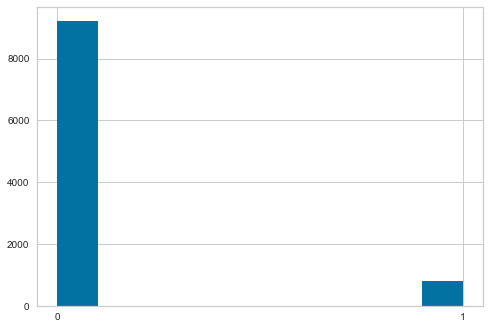

0    9213
1     796
Name: SIU_CUST_YN, dtype: int64
0.07952842441802378


In [190]:
plt.hist(cluster_y_train)
plt.xticks([0,1])
plt.show()

print(cluster_y_train.value_counts())
print(796/(796+9213))

### SMOTE 적용
 - SMOTE, Boarderline-SMOTE, ADASYN 중 가장 높은 재현율을 보여주는 ADASYN를 사용

In [234]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# x_train_over,y_train_over = smote.fit_resample(cluster_x_train,cluster_y_train)

# print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', cluster_x_train.shape, cluster_y_train.shape)
# print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
# print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

In [235]:
# from imblearn.over_sampling import BorderlineSMOTE

# bsmote = BorderlineSMOTE(random_state=42)
# x_train_over,y_train_over = bsmote.fit_resample(cluster_x_train,cluster_y_train)

# print('BorderlineSMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', cluster_x_train.shape, cluster_y_train.shape)
# print('BorderlineSMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
# print('BorderlineSMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

In [225]:
from imblearn.over_sampling import ADASYN

ads = ADASYN(random_state=42)
x_train_over,y_train_over = ads.fit_resample(cluster_x_train,cluster_y_train)

print('ADASYN 적용 전 학습용 피처/레이블 데이터 세트: ', cluster_x_train.shape, cluster_y_train.shape)
print('ADASYN 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('ADASYN 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

ADASYN 적용 전 학습용 피처/레이블 데이터 세트:  (10009, 84) (10009,)
ADASYN 적용 후 학습용 피처/레이블 데이터 세트:  (18464, 84) (18464,)
ADASYN 적용 후 레이블 값 분포: 
 1    9251
0    9213
Name: SIU_CUST_YN, dtype: int64


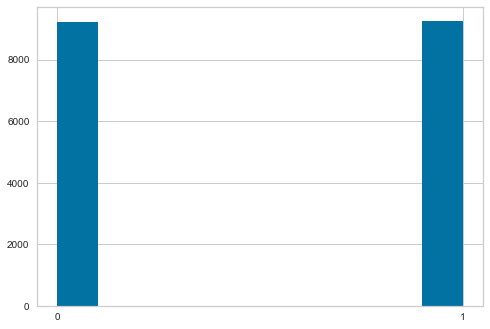

1    9251
0    9213
Name: SIU_CUST_YN, dtype: int64
0.5010290294627383


In [197]:
plt.hist(y_train_over)
plt.xticks([0,1])
plt.show()

print(y_train_over.value_counts())
print(9251/(9213+9251))

### 모델 생성 및 평가

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [226]:
# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=42)

# DecisionTreeClassifer 학습.

dt_clf.fit(x_train_over, y_train_over)# train데이터 fit 

pred = dt_clf.predict(real_x_test)

In [227]:
cf = confusion_matrix(y_test, pred, labels=[1, 0])
print("confusion_matrix : ")
print(cf)
print()
r = recall_score(y_test, pred, labels=[1, 0])
print("recall_score : " ,r)

confusion_matrix : 
[[ 117   68]
 [1085  789]]

recall_score :  0.6324324324324324


##### 하이퍼 파라미터 확인

In [228]:
# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


##### GridSearchCV를 이용하여 최적의 depth를 찾음
##### max_depth와 min_samples_split를 이용하여 튜닝

In [229]:
dt_clf = DecisionTreeClassifier(random_state=42)

params = {
    'max_depth' : [3, 6, 9, 12, 15 ,18, 21, 24, 27, 30 ], 
    'min_samples_split' : [2, 4, 6, 8, 10],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='recall', cv=5, verbose=1 )
grid_cv.fit(x_train_over , y_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_)) 
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
GridSearchCV 최고 평균 정확도 수치: 0.8052
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 24, 'min_samples_split': 2}


##### depth별 정확도 확인

In [220]:
# # GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
# cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# # max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
# cv_results_df[['param_max_depth', 'mean_test_score']] 

# max_depths = [3, 6, 9, 12, 15 ,18, 21, 24 ,27,30]
# # max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
# for depth in max_depths:
#     dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
#     dt_clf.fit(x_train_over,y_train_over) # train 데이터 fit
#     pred = dt_clf.predict(real_x_test) # test 데이터 predict 하기
#     recall = recall_score(y_test , pred, labels=[1, 0])
#     print('max_depth = {0} 재현율: {1:.4f}'.format(depth , recall))

##### 모델 평가

In [230]:
best_df_clf = grid_cv# GrideSearch 최적의 파라미터 
pred1 = best_df_clf.predict(real_x_test)
recall = recall_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 재현율:{0:.4f}'.format(recall))

결정 트리 예측 재현율:0.6432


In [231]:
precision = precision_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 정밀도:{0:.4f}'.format(precision))

결정 트리 예측 정밀도:0.0975


In [232]:
f1 = f1_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 f1:{0:.4f}'.format(f1))

결정 트리 예측 f1:0.1694


In [233]:
cf = confusion_matrix(y_test, pred1, labels=[1, 0])
print("confusion_matrix : ")
print(cf)
print()

confusion_matrix : 
[[ 119   66]
 [1101  773]]



##### graphviz로 모델 시각화
 - 첫번째 의사결정은 청구횟수
 - 두번쨰 의사결정은 청구사유가 입원인지 통원인지 

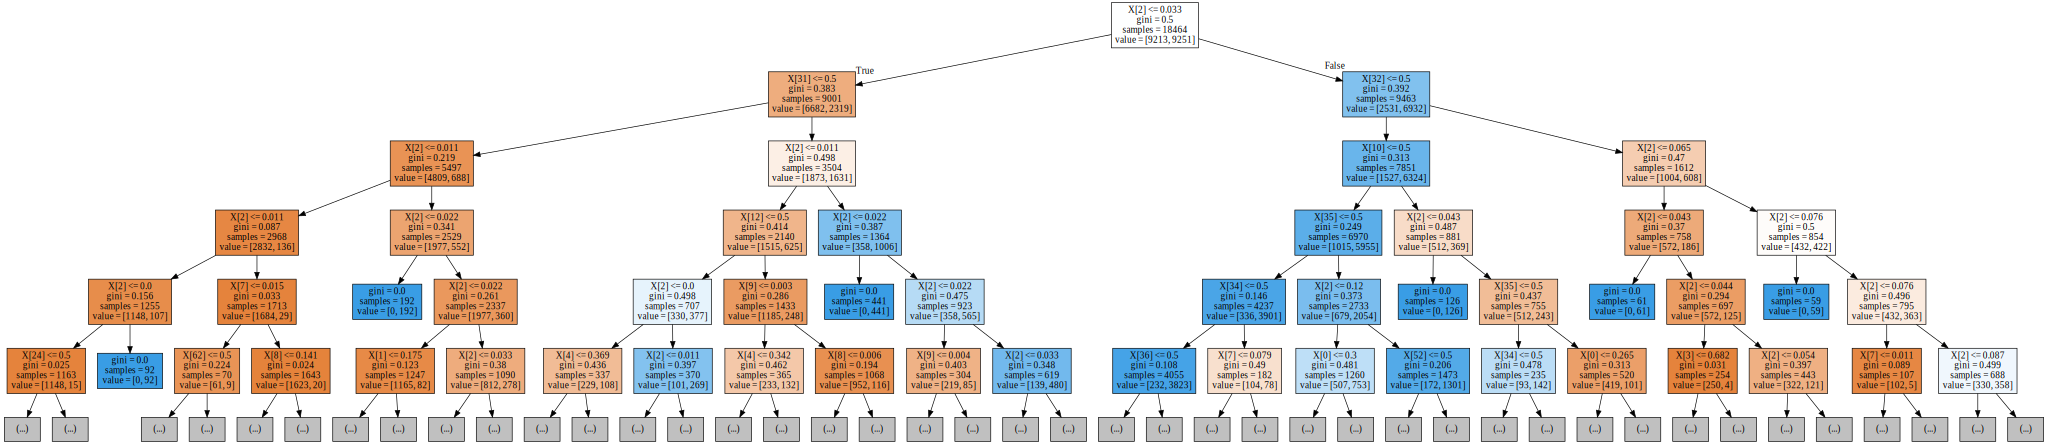

In [236]:
# # DecicionTreeClassifier 생성 (max_depth = 3 으로 제한)
dt_clf = DecisionTreeClassifier(max_depth=24, min_samples_split=2, random_state=42)
dt_clf.fit(x_train_over, y_train_over)

# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, max_depth=5, out_file="tree.dot", impurity=True, filled=True)

import graphviz
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## 번외. SMOTE를 안했을 경우

##### 모델 생성 후 튜닝

In [237]:
dt_clf = DecisionTreeClassifier(random_state=42)

params = {
    'max_depth' : [3, 6, 9, 12, 15 ,18, 21, 24, 27, 30 ], 
    'min_samples_split' : [2, 4, 6, 8, 10]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='recall', cv=5, verbose=1 )
grid_cv.fit(cluster_x_train , cluster_y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_)) 
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
GridSearchCV 최고 평균 정확도 수치: 0.3170
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 15, 'min_samples_split': 8}


##### 모델 평가

In [238]:
best_df_clf = grid_cv# GrideSearch 최적의 파라미터 
pred1 = best_df_clf.predict(real_x_test)
recall = recall_score(y_test , pred1)
print('결정 트리 예측 재현율:{0:.4f}'.format(recall))

결정 트리 예측 재현율:0.2757


In [239]:
precision = precision_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 정밀도:{0:.4f}'.format(precision))

결정 트리 예측 정밀도:0.3806


In [240]:
f1 = f1_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 f1:{0:.4f}'.format(f1))

결정 트리 예측 f1:0.3197


In [241]:
cf = confusion_matrix(y_test, pred1, labels=[1, 0])
print("confusion_matrix : ")
print(cf)
print()

confusion_matrix : 
[[  51  134]
 [  83 1791]]



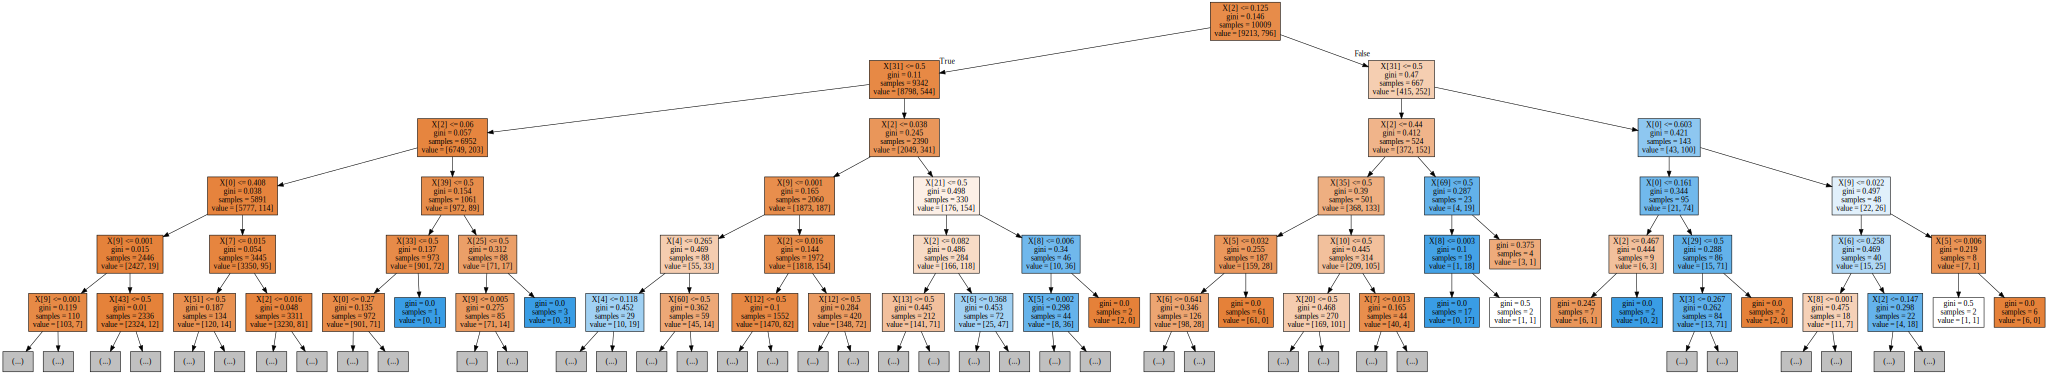

In [242]:
# # DecicionTreeClassifier 생성 (max_depth = 3 으로 제한)
dt_clf = DecisionTreeClassifier(max_depth=15, min_samples_split=8 ,random_state=42)
dt_clf.fit(cluster_x_train, cluster_y_train)

# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, max_depth=5, out_file="tree.dot", impurity=True, filled=True)

import graphviz
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# 7. RandomForest

## SMOTE 적용
##### SMOTE, Boarderline-SMOTE, ADASYN 중 가장 높은 재현율을 보여주는 ADASYN를 사용

In [278]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# x_train_over,y_train_over = smote.fit_resample(cluster_x_train,cluster_y_train)

# print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', cluster_x_train.shape, cluster_y_train.shape)
# print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
# print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

In [279]:
# from imblearn.over_sampling import BorderlineSMOTE

# bsmote = BorderlineSMOTE(random_state=42)
# x_train_over,y_train_over = bsmote.fit_resample(cluster_x_train,cluster_y_train)

# print('BorderlineSMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', cluster_x_train.shape, cluster_y_train.shape)
# print('BorderlineSMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
# print('BorderlineSMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

In [270]:
from imblearn.over_sampling import ADASYN

ads = ADASYN(random_state=42)
x_train_over,y_train_over = ads.fit_resample(cluster_x_train,cluster_y_train)

print('ADASYN 적용 전 학습용 피처/레이블 데이터 세트: ', cluster_x_train.shape, cluster_y_train.shape)
print('ADASYN 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('ADASYN 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

ADASYN 적용 전 학습용 피처/레이블 데이터 세트:  (10009, 84) (10009,)
ADASYN 적용 후 학습용 피처/레이블 데이터 세트:  (18464, 84) (18464,)
ADASYN 적용 후 레이블 값 분포: 
 1    9251
0    9213
Name: SIU_CUST_YN, dtype: int64


In [244]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

##### 튜닝 전

In [271]:
# DecisionTree Classifier 생성
rf_clf = RandomForestClassifier(random_state=42)

# DecisionTreeClassifer 학습.


rf_clf.fit(x_train_over, y_train_over)# train데이터 fit 

pred = rf_clf.predict(real_x_test)

In [272]:
cf = confusion_matrix(y_test, pred, labels=[1, 0])
print("confusion_matrix : ")
print(cf)
print()
r = recall_score(y_test, pred, labels=[1, 0])
print("recall_score : " ,r)

confusion_matrix : 
[[  87   98]
 [ 114 1760]]

recall_score :  0.4702702702702703


##### 튜닝 후

In [273]:
rf_clf = RandomForestClassifier(random_state=42)

params = {
    'n_estimators' : [10,40,70],
    'max_depth' : [3, 6, 9, 12, 15 ,18, 21, 24, 27], 
    'min_samples_split' : [2, 4, 6]
}

grid_cv = GridSearchCV(rf_clf, param_grid=params, scoring='recall', cv=5, verbose=1 )
grid_cv.fit(x_train_over , y_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_)) 
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
GridSearchCV 최고 평균 정확도 수치: 0.7809
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 40}


##### 모델 평가

In [274]:
best_rf_clf = grid_cv# GrideSearch 최적의 파라미터 
pred1 = best_rf_clf.predict(real_x_test)
recall = recall_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 재현율:{0:.4f}'.format(recall))

결정 트리 예측 재현율:0.5027


In [275]:
precision = precision_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 정밀도:{0:.4f}'.format(precision))

결정 트리 예측 정밀도:0.3432


In [276]:
f1 = f1_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 f1:{0:.4f}'.format(f1))

결정 트리 예측 f1:0.4079


In [277]:
cf = confusion_matrix(y_test, pred1, labels=[1, 0])
print("confusion_matrix : ")
print(cf)
print()

confusion_matrix : 
[[  93   92]
 [ 178 1696]]



### 번외. SMOTE를 안했을 경우

In [280]:
rf_clf = RandomForestClassifier(random_state=42)

params = {
    'n_estimators' : [10,40,70],
    'max_depth' : [3, 6, 9, 12, 15 ,18, 21, 24, 27 ], 
    'min_samples_split' : [2, 4, 6, 8]
}

grid_cv = GridSearchCV(rf_clf, param_grid=params, scoring='recall', cv=5, verbose=1 )
grid_cv.fit(cluster_x_train , cluster_y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_)) 
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV 최고 평균 정확도 수치: 0.1673
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 21, 'min_samples_split': 4, 'n_estimators': 40}


##### 모델 평가

In [281]:
best_rf_clf = grid_cv# GrideSearch 최적의 파라미터 
pred1 = best_rf_clf.predict(real_x_test)
recall = recall_score(y_test , pred1)
print('결정 트리 예측 재현율:{0:.4f}'.format(recall))

결정 트리 예측 재현율:0.1297


In [282]:
precision = precision_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 정밀도:{0:.4f}'.format(precision))

결정 트리 예측 정밀도:0.8276


In [283]:
f1 = f1_score(y_test , pred1, labels=[1, 0])
print('결정 트리 예측 f1:{0:.4f}'.format(f1))

결정 트리 예측 f1:0.2243


In [284]:
cf = confusion_matrix(y_test, pred1, labels=[1, 0])
print("confusion_matrix : ")
print(cf)
print()

confusion_matrix : 
[[  24  161]
 [   5 1869]]



## 검증 데이터의 보험사기자 특성 분석

In [269]:
# int_x_test = x_test.loc[real_x_test.index][columns]

# str_x_test = real_x_test[list(real_x_test.columns.difference(columns))]

# summary_int_x_test_Y = pd.concat([ int_x_test.loc[y_test.loc[y_test == 1].index][explain[0]].describe(), int_x_test.loc[y_test.loc[y_test == 1].index][explain[1]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 1].index][explain[2]].describe(), int_x_test.loc[y_test.loc[y_test == 1].index][explain[3]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 1].index][explain[4]].describe(), int_x_test.loc[y_test.loc[y_test == 1].index][explain[5]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 1].index][explain[6]].describe(), int_x_test.loc[y_test.loc[y_test == 1].index][explain[7]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 1].index][explain[8]].describe()], axis = 1)

# summary_int_x_test_N = pd.concat([ int_x_test.loc[y_test.loc[y_test == 0].index][explain[0]].describe(), int_x_test.loc[y_test.loc[y_test == 0].index][explain[1]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 0].index][explain[2]].describe(), int_x_test.loc[y_test.loc[y_test == 0].index][explain[3]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 0].index][explain[4]].describe(), int_x_test.loc[y_test.loc[y_test == 0].index][explain[5]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 0].index][explain[6]].describe(), int_x_test.loc[y_test.loc[y_test == 0].index][explain[7]].describe(),\
#           int_x_test.loc[y_test.loc[y_test == 0].index][explain[8]].describe()], axis = 1)

# summary_str_x_test_Y_RESN = pd.concat([ str_x_test.loc[y_test.loc[y_test == 1].index][explain[9]].groupby(str_x_test[explain[9]]).count(), str_x_test.loc[y_test.loc[y_test == 1].index][explain[10]].groupby(str_x_test[explain[10]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 1].index][explain[11]].groupby(str_x_test[explain[11]]).count(), str_x_test.loc[y_test.loc[y_test == 1].index][explain[12]].groupby(str_x_test[explain[12]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 1].index][explain[13]].groupby(str_x_test[explain[13]]).count(), str_x_test.loc[y_test.loc[y_test == 1].index][explain[14]].groupby(str_x_test[explain[14]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 1].index][explain[15]].groupby(str_x_test[explain[15]]).count(), str_x_test.loc[y_test.loc[y_test == 1].index][explain[16]].groupby(str_x_test[explain[16]]).count() ], axis = 1)

# summary_str_x_test_N_RESN = pd.concat([ str_x_test.loc[y_test.loc[y_test == 0].index][explain[9]].groupby(str_x_test[explain[9]]).count(), str_x_test.loc[y_test.loc[y_test == 0].index][explain[10]].groupby(str_x_test[explain[10]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 0].index][explain[11]].groupby(str_x_test[explain[11]]).count(), str_x_test.loc[y_test.loc[y_test == 0].index][explain[12]].groupby(str_x_test[explain[12]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 0].index][explain[13]].groupby(str_x_test[explain[13]]).count(), str_x_test.loc[y_test.loc[y_test == 0].index][explain[14]].groupby(str_x_test[explain[14]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 0].index][explain[15]].groupby(str_x_test[explain[15]]).count(), str_x_test.loc[y_test.loc[y_test == 0].index][explain[16]].groupby(str_x_test[explain[16]]).count() ], axis = 1)

# summary_str_x_test_Y_ACCI = pd.concat([ str_x_test.loc[y_test.loc[y_test == 1].index][explain[17]].groupby(str_x_test[explain[17]]).count(), str_x_test.loc[y_test.loc[y_test == 1].index][explain[18]].groupby(str_x_test[explain[18]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 1].index][explain[19]].groupby(str_x_test[explain[19]]).count() ], axis = 1)

# summary_str_x_test_N_ACCI = pd.concat([ str_x_test.loc[y_test.loc[y_test == 0].index][explain[17]].groupby(str_x_test[explain[17]]).count(), str_x_test.loc[y_test.loc[y_test == 0].index][explain[18]].groupby(str_x_test[explain[18]]).count(),\
#           str_x_test.loc[y_test.loc[y_test == 0].index][explain[19]].groupby(str_x_test[explain[19]]).count() ], axis = 1)

# summary_str_x_test_Y_SEX = pd.concat([ str_x_test.loc[y_test.loc[y_test == 1].index][explain[20]].groupby(str_x_test[explain[20]]).count(),\
#                                       str_x_test.loc[y_test.loc[y_test == 1].index][explain[21]].groupby(str_x_test[explain[21]]).count() ], axis = 1)

# summary_str_x_test_N_SEX = pd.concat([ str_x_test.loc[y_test.loc[y_test == 0].index][explain[20]].groupby(str_x_test[explain[20]]).count(),\
#                                       str_x_test.loc[y_test.loc[y_test == 0].index][explain[21]].groupby(str_x_test[explain[21]]).count() ], axis = 1)

# print(len(real_x_test.loc[y_test.loc[y_test == 0].index]))
# print(len(real_x_test.loc[y_test.loc[y_test == 1].index]))
# print(len(real_x_test.loc[y_test.loc[y_test == 1].index]) / (len(real_x_test.loc[y_test.loc[y_test == 1].index]) + len(real_x_test.loc[y_test.loc[y_test == 0].index])))

# print("보험사기자인 고객들의 숫자정보")
# print(summary_int_x_test_Y)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자가 아닌 고객들의 숫자정보")
# print(summary_int_x_test_N)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자인 고객들의 청구사유")
# print(summary_str_x_test_Y_RESN)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자가 아닌 고객들의 청구사유")
# print(summary_str_x_test_N_RESN)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자인 고객들의 사고구분")
# print(summary_str_x_test_Y_ACCI)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자가 아닌 고객들의 사고구분")
# print(summary_str_x_test_N_ACCI)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자인 고객들의 성별")
# print(summary_str_x_test_Y_SEX)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()
# print("보험사기자가 아닌 고객들의 성별")
# print(summary_str_x_test_N_SEX)
# print('----------------------------------------------------------------------------------')
# print('----------------------------------------------------------------------------------')
# print()

# 370/ 1874         

#  833    / (833 +1041     ) 